In [44]:
# Import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
import yfinance as yf
from datetime import timedelta
import statsmodels.api as sm
import matplotlib.dates as mdates

In [45]:
# LOAD DIVIDEND ARISTOCRATS LIST

# Load csv file
da_raw = pd.read_csv("dividend_aristocrats_03.10.23.csv")

# Rename column
da_raw = da_raw.rename(columns = {"Ticker": "symbol"})

# Remove irrelevant columns
remove = ["Years of Dividend Increases","1-Year Dividend Growth","5-Year Dividend Growth (Annualized)",
          "Dividends Per Share (TTM)","Market Cap ($M)","Trailing P/E Ratio","Payout Ratio","Beta",
          "52-Week High","52-Week Low", "Dividend Yield","Name","Price","Sector","Price"]
da_raw = da_raw[da_raw.columns.difference(remove)]

# List of companies to drop because data is incomplete for the time period applied
lst = ["ATO", "CB", "CTAS", "MCD", "SPGI", "EXPD", "ABBV", "LIN", "AMCR", "BF.B", "O"]

# Create a boolean mask where True indicates rows to keep
mask = ~da_raw['symbol'].isin(lst)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
da = da_raw[mask]

# Convert to list
da_lst = da["symbol"].tolist()


In [46]:
all_data = pd.read_csv("historical_prices_with_dividends.csv")

#print(all_data.head(15))


In [47]:
# DATA PREPARATION 1/2

# Create object for start year
#start_date = pd.to_datetime(start_date)
#start_year = start_date.year  

# Create object for end year
#end_date = pd.to_datetime(end_date)
#end_year = end_date.year  

all_data_ml = all_data

# Save the data to a CSV file
all_data_ml.to_csv('all_data_ml.csv', index = False)

# Rename and remove columns
all_data = all_data.rename(columns = {
    "Symbol": "symbol", "Date": "date", "Dividends": "dividend", "Adj Close": "close_adjusted"})
remove = ["Open", "High", "Low", "Close", "Volume"]
all_data_cleaned = all_data[all_data.columns.difference(remove)]

# Save the data to a CSV file
all_data_cleaned.to_csv('all_data_cleaned.csv', index = False)


In [48]:
# DATA PREPARATION 2/2

# Create df that is to contain dates halfway between the ex-dividend dates  
dd_raw = all_data_cleaned
dd_raw = dd_raw.sort_values(by = ["symbol", "date"])

dd_halfway = dd_raw

# Convert the "date" column to datetime
dd_halfway['date'] = pd.to_datetime(dd_halfway['date'])

# Sort the DataFrame by "symbol" and then "date"
dd_halfway = dd_halfway.sort_values(by = ["symbol", "date"])

# Function to find the nearest weekday
def nearest_weekday(dt):
    if dt.weekday() >= 5:  # If Saturday or Sunday, move to Monday
        return dt + timedelta(days = (7 - dt.weekday()) % 5)
    else:
        return dt

# Calculate the halfway date
dd_halfway['halfway_date'] = dd_halfway['date'].shift(1) + (dd_halfway['date'] - dd_halfway[
    'date'].shift(1)) / 2
dd_halfway['halfway_date'] = dd_halfway['halfway_date'].apply(nearest_weekday)

# convert date columns to string
dd_halfway["date"] = dd_halfway["date"].astype(str)
dd_halfway["halfway_date"] = dd_halfway["halfway_date"].astype(str)

# Create new df "halfway_date", drop and rename date columns
halfway_date = dd_halfway
halfway_date = halfway_date.drop(["dividend", "date"], axis = 1)
halfway_date = halfway_date.rename(columns = {"halfway_date": "date"})

# Convert the date column to datetime type
halfway_date['date'] = pd.to_datetime(halfway_date['date'])

# Remove the time component
halfway_date['date'] = halfway_date['date'].dt.date
halfway_date['date'] = pd.to_datetime(halfway_date['date'])


In [49]:
# DCS SELECTED HALFWAY: Performance Analysis MONTHLY !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1

import exchange_calendars as xcals
from datetime import time
import pandas_market_calendars as mcal
from pandas_market_calendars import get_calendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import timedelta

#
all_data_cleaned = pd.read_csv("all_data_cleaned.csv")

all_data_cleaned=all_data_cleaned.sort_values(['symbol', 'date'], ascending = [
    True, True]).reset_index(drop = True)

# Sort values to ensure correct reading of data prior to analysis
sp_dd_da_merged = all_data_cleaned

# Create copy of df to be used later
sp_dd_da_merged_selected = sp_dd_da_merged

# Save the data to a CSV file
sp_dd_da_merged.to_csv('sp_dd_da_merged.csv', index = False)
sp_dd_da_merged_selected.to_csv('sp_dd_da_merged_selected.csv', index = False)

# Create copy of df to be used later
ff = sp_dd_da_merged

ff.to_csv("ff.csv",index=False)

# Function to loop through the 2 pairs of dividend stocks to calculate the profitability 
def dcs_avg_das(lst_1, lst_2):

    # Set sp_dd_da_merged to global to ensure usability outside function
    global sp_dd_da_merged 
    
    # Create dfs for each pair of stocks 
    sp_dd_da_merged_1 = sp_dd_da_merged[sp_dd_da_merged["symbol"].isin(lst_1)] 
    sp_dd_da_merged_2 = sp_dd_da_merged[sp_dd_da_merged["symbol"].isin(lst_2)]

    # Sort dfs by date 
    sp_dd_da_merged_1 = sp_dd_da_merged_1.sort_values(['date'], ascending = [
        True]).reset_index(drop = True)
    sp_dd_da_merged_2 = sp_dd_da_merged_2.sort_values(['date'], ascending = [
        True]).reset_index(drop = True)

    # Create new column "key" to act as key to connect data later on
    sp_dd_da_merged_1["key"] = sp_dd_da_merged_1["date"] + sp_dd_da_merged_1["symbol"]
    sp_dd_da_merged_2["key"] = sp_dd_da_merged_2["date"] + sp_dd_da_merged_2["symbol"]

    # Create new dfs that are to contain only ex-dividend dates 
    sp_dd_da_onlydd_1 = sp_dd_da_merged_1
    sp_dd_da_onlydd_2 = sp_dd_da_merged_2

    # Ensure date columns are in datetime format
    sp_dd_da_onlydd_1['date'] = pd.to_datetime(sp_dd_da_onlydd_1['date'])
    sp_dd_da_onlydd_2['date'] = pd.to_datetime(sp_dd_da_onlydd_2['date'])

    # Filter the df to only have ex-dividend dates
    sp_dd_da_onlydd_1 = sp_dd_da_onlydd_1.loc[(sp_dd_da_onlydd_1["dividend"] > 0)]
    sp_dd_da_onlydd_2 = sp_dd_da_onlydd_2.loc[(sp_dd_da_onlydd_2["dividend"] > 0)]

    # Reset indices
    sp_dd_da_onlydd_1.reset_index(inplace = True, drop = True)
    sp_dd_da_onlydd_2.reset_index(inplace = True, drop = True)

#-------------------------------------------------------------------------------------------- 

    # Function to find the nearest weekday
    def nearest_weekday(dt):
        if dt.weekday() >= 5:  # If Saturday or Sunday, move to Monday
            return dt + timedelta(days = (7 - dt.weekday()) % 5)
        else:
            return dt

    # Create copies to keep the origninal df unchanged 
    sp_dd_da_onlydd_1 = sp_dd_da_onlydd_1.copy()
    sp_dd_da_onlydd_2 = sp_dd_da_onlydd_2.copy()
    
    # Calculate the halfway date
    sp_dd_da_onlydd_1 = sp_dd_da_onlydd_1.copy()
    sp_dd_da_onlydd_2 = sp_dd_da_onlydd_2.copy()

    # Calculate the halfway date
    sp_dd_da_onlydd_1['halfway_date'] = sp_dd_da_onlydd_1['date'].shift(1) + (
        sp_dd_da_onlydd_1['date'] - sp_dd_da_onlydd_1['date'].shift(1)) / 2
    sp_dd_da_onlydd_2['halfway_date'] = sp_dd_da_onlydd_2['date'].shift(1) + (
        sp_dd_da_onlydd_2['date'] - sp_dd_da_onlydd_2['date'].shift(1)) / 2

    # Apply function "nearest_weekday" to ensure halfway dates are weekdays
    sp_dd_da_onlydd_1['halfway_date'] = sp_dd_da_onlydd_1['halfway_date'].apply(nearest_weekday)
    sp_dd_da_onlydd_2['halfway_date'] = sp_dd_da_onlydd_2['halfway_date'].apply(nearest_weekday)

    # Remove the time component
    sp_dd_da_onlydd_1['halfway_date'] = sp_dd_da_onlydd_1['halfway_date'].dt.date
    sp_dd_da_onlydd_2['halfway_date'] = sp_dd_da_onlydd_2['halfway_date'].dt.date

    # Convert to datetime format
    sp_dd_da_onlydd_1['halfway_date'] = pd.to_datetime(sp_dd_da_onlydd_1['halfway_date'])
    sp_dd_da_onlydd_2['halfway_date'] = pd.to_datetime(sp_dd_da_onlydd_2['halfway_date'])

#--------------------------------------------------------------------------------------------

    # Function to ensure dates halfway between ex-dividend dates are on 
    # open business days (US calendar)    
    def yours_1(sp_dd_da_onlydd_1):
        
        # Load US calendar with holidys and business days
        nyse = mcal.get_calendar('NYSE')
        holidays = nyse.holidays()
        holidays = list(holidays.holidays)
        
        # Create object that contains only the business days
        US_BUSINESS_DAY = CustomBusinessDay(holidays = holidays)

        # Create object that is a copy of the 
        result_1 = sp_dd_da_onlydd_1['halfway_date'].copy()

        for i, date in enumerate(sp_dd_da_onlydd_1['halfway_date']):
            if date in holidays:
                result_1.iloc[i] = date - 1 * US_BUSINESS_DAY

        sp_dd_da_onlydd_1['adjusted_date'] = result_1

        return sp_dd_da_onlydd_1

    # Function to ensure dates halfway between ex-dividend dates are on 
    # open business days (US calendar)    
    def yours_2(sp_dd_da_onlydd_2):
        nyse = mcal.get_calendar('NYSE')
        holidays = nyse.holidays()
        holidays = list(holidays.holidays)
        US_BUSINESS_DAY = CustomBusinessDay(holidays = holidays)

        result_2 = sp_dd_da_onlydd_2['halfway_date'].copy()

        for i, date in enumerate(sp_dd_da_onlydd_2['halfway_date']):
            if date in holidays:
                result_2.iloc[i] = date - 1 * US_BUSINESS_DAY

        sp_dd_da_onlydd_2['adjusted_date'] = result_2

        return sp_dd_da_onlydd_2

    # Apply function above and create a copy to keep the original DataFrame unchanged
    result_df_1 = yours_1(sp_dd_da_onlydd_1.copy())
    result_df_2 = yours_2(sp_dd_da_onlydd_2.copy()) 

    # Duplicate above dfs for later use
    halfway_dates_1 = result_df_1
    halfway_dates_2 = result_df_2

    only_dd_1 = result_df_1
    only_dd_2 = result_df_2

    # Convert date columns to string to be able to create key below
    halfway_dates_1["adjusted_date"] = halfway_dates_1["adjusted_date"].astype(str)
    halfway_dates_2["adjusted_date"] = halfway_dates_2["adjusted_date"].astype(str)

    # Create new column that contains key
    halfway_dates_1["key"] = halfway_dates_1["adjusted_date"] + halfway_dates_1["symbol"]
    halfway_dates_2["key"] = halfway_dates_2["adjusted_date"] + halfway_dates_2["symbol"]

    # Remove unnecessary columns
    halfway_dates_1 = halfway_dates_1.drop(["close_adjusted", "dividend"], axis = 1)
    halfway_dates_2 = halfway_dates_2.drop(["close_adjusted", "dividend"], axis = 1)

    # Merge halfway_dates with sp_dd_da_merged so that prices, dividend and dividend dates, 
    # as well as halfway dates og prices priser are included

    # Convert date columns to string to be able to create key below
    result_df_1["adjusted_date"] = result_df_1["adjusted_date"].astype(str)
    result_df_2["adjusted_date"] = result_df_2["adjusted_date"].astype(str)

    # Create new column that contains key
    result_df_1["key"] = result_df_1["adjusted_date"] + result_df_1["symbol"]
    result_df_2["key"] = result_df_2["adjusted_date"] + result_df_2["symbol"]

    # Create new column that contains key
    only_dd_1["key"] = only_dd_1["adjusted_date"] + only_dd_1["symbol"]
    only_dd_2["key"] = only_dd_2["adjusted_date"] + only_dd_2["symbol"]

    # Remove price column
    only_dd_1 = only_dd_1.drop(["close_adjusted"], axis = 1)
    only_dd_2 = only_dd_2.drop(["close_adjusted"], axis = 1)

    # Ensure that NaN values are removed to avoid issues
    only_dd_1 = only_dd_1.dropna()
    only_dd_2 = only_dd_2.dropna()

    # Remove dividend columns
    result_df_1 = result_df_1.drop(["dividend"], axis = 1)
    result_df_2 = result_df_2.drop(["dividend"], axis = 1)

    # Merge "halfway_dates" and "sp_dd_da_merged"
    
    # Merge df containing dividends with df that contains halfway dates
    halfway_date_onlydd_prices_1 = pd.merge(
        halfway_dates_1, sp_dd_da_merged_1, how = "left", on = ["key"])
    halfway_date_onlydd_prices_2 = pd.merge(
        halfway_dates_2, sp_dd_da_merged_2, how = "left", on = ["key"])

    # Merge above df with df that only contains dividend dates
    halfway_date_onlydd_prices_final_1 = pd.merge(
        halfway_date_onlydd_prices_1, only_dd_1, how = "outer", on = ["key"])
    halfway_date_onlydd_prices_final_2 = pd.merge(
        halfway_date_onlydd_prices_2, only_dd_2, how = "outer", on = ["key"])

    # Remove columns
    halfway_date_onlydd_prices_final_1 = halfway_date_onlydd_prices_final_1.drop(
        columns = ["date_y", "dividend_x", "symbol_y", "date", "symbol_x", 
                   "halfway_date_y", "adjusted_date_y"])
    halfway_date_onlydd_prices_final_2 = halfway_date_onlydd_prices_final_2.drop(
        columns = ["date_y", "dividend_x", "symbol_y", "date", "symbol_x", 
                   "halfway_date_y", "adjusted_date_y"])

    # Create new df and convert to datetime
    halfway_stock_lst_1 = halfway_date_onlydd_prices_final_1
    halfway_stock_lst_1["halfway_date_x"] = pd.to_datetime(halfway_stock_lst_1['halfway_date_x'])
    
    # Create new df and convert to datetime
    halfway_stock_lst_2 = halfway_date_onlydd_prices_final_2
    halfway_stock_lst_2["halfway_date_x"] = pd.to_datetime(halfway_stock_lst_2['halfway_date_x'])
    
    # Create new dfs
    sp_dd_da_merged_lst_1 = sp_dd_da_merged
    sp_dd_da_merged_lst_2 = sp_dd_da_merged
    
    # Rename column
    sp_dd_da_merged = sp_dd_da_merged.rename(columns = {"date": "adjusted_date_x"})
    
    

    # LIST 1

    # Step 1: Get symbols from list and rename
    sp_dd_da_merged_lst_1_0 = sp_dd_da_merged_lst_1[sp_dd_da_merged_lst_1["symbol"] == lst_1[0]]
    sp_dd_da_merged_lst_1_0 = sp_dd_da_merged_lst_1_0.rename(columns={"date": "halfway_date_x"})

    # Step 2: Get symbols from list and rename
    sp_dd_da_merged_lst_1_1 = sp_dd_da_merged_lst_1[sp_dd_da_merged_lst_1["symbol"] == lst_1[1]]
    sp_dd_da_merged_lst_1_1 = sp_dd_da_merged_lst_1_1.rename(columns={"date": "halfway_date_x"})

    # Step 3: Convert to datetime
    sp_dd_da_merged_lst_1_0["halfway_date_x"] = pd.to_datetime(sp_dd_da_merged_lst_1_0['halfway_date_x'])
    sp_dd_da_merged_lst_1_1["halfway_date_x"] = pd.to_datetime(sp_dd_da_merged_lst_1_1['halfway_date_x'])

    # Step 4: Merge dfs on date
    merged_lst_1 = pd.merge(sp_dd_da_merged_lst_1_1, halfway_stock_lst_1, how="right", on=["halfway_date_x"])

    # Step 5: Drop dividend column
    sp_dd_da_merged_lst_1_0 = sp_dd_da_merged_lst_1_0.drop(["dividend"], axis=1)

    # Step 6: Merge dfs on date
    merged_lst_1 = pd.merge(sp_dd_da_merged_lst_1_0, merged_lst_1, how="right", on=["halfway_date_x"])

    # Step 7: Drop unnecessary columns
    merged_lst_1 = merged_lst_1.drop(columns=["halfway_date_x", "symbol", "symbol_x", "key"])

    # Step 8: Function to create new column based on conditions
    def create_new_column(row):
        if row.name % 2 == 0:  # Even index
            return row['close_adjusted']
        else:  # Odd index
            return row['close_adjusted_x']

    # Step 9: Apply above function
    merged_lst_1['close_adjusted_z'] = merged_lst_1.apply(create_new_column, axis=1)

    # Step 10: Convert to datetime
    merged_lst_1["adjusted_date_x"] = pd.to_datetime(merged_lst_1["adjusted_date_x"])

    # Step 11: Drop the last row as it will have NaN in the 'diff' column
    merged_lst_1 = merged_lst_1[:-1]

    # Step 12: Calculate dollar return
    merged_lst_1['diff'] = merged_lst_1['close_adjusted_z'].shift(-1) + merged_lst_1[
        "dividend_y"] - merged_lst_1['close_adjusted_z']

    # Step 13: Calculate the percentual difference
    merged_lst_1["diff_perc"] = merged_lst_1['diff'] / merged_lst_1['close_adjusted_z']

    # Drop unnecessary columns
    merged_lst_1 = merged_lst_1.drop(columns=["symbol_y"])

    # If needed, reset the index to ensure monthly data continuity
    merged_lst_1 = merged_lst_1.reset_index(drop=True)

    # Remove rows with NaN in the diff column
    merged_lst_1 = merged_lst_1.dropna(subset=['diff'])
    
    # Calculate accumulated difference
    merged_lst_1["diff_acc"] = merged_lst_1["diff"].cumsum()
    merged_lst_1["diff_acc_perc"] = merged_lst_1["diff_perc"].cumsum()

    # Normalize first value to 100
    merged_lst_1['normalized_diff_acc'] = merged_lst_1["diff_acc"] / merged_lst_1["diff_acc"].iloc[0] * 100
    merged_lst_1['normalized_diff_acc_perc'] = merged_lst_1["diff_acc_perc"] / merged_lst_1["diff_acc_perc"].iloc[0] * 100

    # Remove rows with NaT in the index
    merged_lst_1 = merged_lst_1.dropna(subset=['adjusted_date_x'])

    # Set the 'adjusted_date_x' column as index
    merged_lst_1.set_index('adjusted_date_x', inplace=True)

    
    merged_lst_1 = merged_lst_1.loc[:,~merged_lst_1.columns.duplicated()].copy()

    
    merged_lst_1 = merged_lst_1.sort_index()
   
    # Fill missing months with most recent data point
    merged_lst_1 = merged_lst_1.resample('M').ffill()
    
    merged_lst_1 = merged_lst_1.rename(columns = {"close_adjusted_z": "close_primo_lst_1"})
    merged_lst_1["profit_lst_1"] = merged_lst_1["diff"]





    # LIST 2

    # Step 1: Get symbols from list and rename
    sp_dd_da_merged_lst_2_0 = sp_dd_da_merged_lst_2[sp_dd_da_merged_lst_2["symbol"] == lst_2[0]]
    sp_dd_da_merged_lst_2_0 = sp_dd_da_merged_lst_2_0.rename(columns={"date": "halfway_date_x"})

    # Step 2: Get symbols from list and rename
    sp_dd_da_merged_lst_2_1 = sp_dd_da_merged_lst_2[sp_dd_da_merged_lst_2["symbol"] == lst_2[1]]
    sp_dd_da_merged_lst_2_1 = sp_dd_da_merged_lst_2_1.rename(columns={"date": "halfway_date_x"})

    # Step 3: Convert to datetime
    sp_dd_da_merged_lst_2_0["halfway_date_x"] = pd.to_datetime(sp_dd_da_merged_lst_2_0[
        'halfway_date_x'])
    sp_dd_da_merged_lst_2_1["halfway_date_x"] = pd.to_datetime(sp_dd_da_merged_lst_2_1[
        'halfway_date_x'])

    # Step 4: Merge dfs on date
    merged_lst_2 = pd.merge(sp_dd_da_merged_lst_2_1, halfway_stock_lst_2, how="right", on=[
        "halfway_date_x"])

    # Step 5: Drop dividend column
    sp_dd_da_merged_lst_2_0 = sp_dd_da_merged_lst_2_0.drop(["dividend"], axis=1)

    # Step 6: Merge dfs on date
    merged_lst_2 = pd.merge(sp_dd_da_merged_lst_2_0, merged_lst_2, how="right", on=["halfway_date_x"])

    # Step 7: Drop unnecessary columns
    merged_lst_2 = merged_lst_2.drop(columns=["halfway_date_x", "symbol", "symbol_x", "key"])

    # Step 8: Function to create new column based on conditions
    def create_new_column(row):
        if row.name % 2 == 0:  # Even index
            return row['close_adjusted']
        else:  # Odd index
            return row['close_adjusted_x']

    # Step 9: Apply above function
    merged_lst_2['close_adjusted_z'] = merged_lst_2.apply(create_new_column, axis=1)

    # Step 10: Convert to datetime
    merged_lst_2["adjusted_date_x"] = pd.to_datetime(merged_lst_2["adjusted_date_x"])

    # Step 11: Drop the last row as it will have NaN in the 'diff' column
    merged_lst_2 = merged_lst_2[:-1]

    # Step 12: Calculate dollar return
    merged_lst_2['diff'] = merged_lst_2['close_adjusted_z'].shift(-1) + merged_lst_2[
        "dividend_y"] - merged_lst_2['close_adjusted_z']

    # Step 13: Calculate the percentual difference
    merged_lst_2["diff_perc"] = merged_lst_2['diff'] / merged_lst_2['close_adjusted_z']

    # Drop unnecessary columns
    merged_lst_2 = merged_lst_2.drop(columns=["symbol_y"])

    # If needed, reset the index to ensure monthly data continuity
    merged_lst_2 = merged_lst_2.reset_index(drop = True)

    # Remove rows with NaN in the diff column
    merged_lst_2 = merged_lst_2.dropna(subset=['diff'])
    #print(merged_lst_2)
    # Calculate accumulated difference
    merged_lst_2["diff_acc"] = merged_lst_2["diff"].cumsum()
    merged_lst_2["diff_acc_perc"] = merged_lst_2["diff_perc"].cumsum()

    # Normalize first value to 100
    merged_lst_2['normalized_diff_acc'] = merged_lst_2[
        "diff_acc"] / merged_lst_2["diff_acc"].iloc[0] * 100
  

    merged_lst_2['normalized_diff_acc_perc'] = merged_lst_2[
        "diff_acc_perc"] / merged_lst_2["diff_acc_perc"].iloc[0] * 100
    
    # Remove rows with NaT in the index
    merged_lst_2 = merged_lst_2.dropna(subset=['adjusted_date_x'])

    # Set the 'adjusted_date_x' column as index
    merged_lst_2.set_index('adjusted_date_x', inplace=True)

    # Remove duplicate columns
    merged_lst_2 = merged_lst_2.loc[:,~merged_lst_2.columns.duplicated()].copy()

    # Sort by index
    merged_lst_2 = merged_lst_2.sort_index()
   
    # Fill missing months with most recent data point
    merged_lst_2 = merged_lst_2.resample('M').ffill()
    
    merged_lst_2 = merged_lst_2.rename(columns = {"close_adjusted_z": "close_primo_lst_2"})
    merged_lst_2["profit_lst_2"] = merged_lst_2["diff"]
    

    # Merge dataframes on date
    pairwise_avgs = pd.merge(merged_lst_1, merged_lst_2, how="inner", on="adjusted_date_x")
        
    #print(pairwise_avgs)
    # Calculate mean accumulated difference across both pair of stocks
    pairwise_avgs["avg"] = (
        pairwise_avgs["normalized_diff_acc_x"] + pairwise_avgs["normalized_diff_acc_y"])
    
    # Calculate average percentual return for the 2 lists
    pairwise_avgs["diff_perc_avg"] = (
        pairwise_avgs["diff_perc_x"] + pairwise_avgs["diff_perc_y"]) / 2

    return pairwise_avgs

##################################################################################################

lst_1 = ["WST","GWW"]
lst_2 = ["APD","LOW"]

##################################################################################################

# Execute function
final_monthly = dcs_avg_das(lst_1, lst_2)

# Remove duplicate columns
final_monthly = final_monthly.loc[:, ~final_monthly.columns.duplicated()].copy()

# Extract year and month from the 'adjusted_date_x' column
final_monthly['year_month'] = pd.to_datetime(final_monthly.index).to_period('M')

final_monthly["dcs_halfway_dollar"] = (final_monthly[["diff_x", "diff_y"]]).sum(axis=1)

final_monthly['diff_perc'] = (
    final_monthly[['profit_lst_1', 'profit_lst_2']].mean(axis=1) / final_monthly[[
        'close_primo_lst_1', 'close_primo_lst_2']].mean(axis=1))

# Print the resulting DataFrame for verification
#print(final_monthly.head(50))





# Create a column to store the shifted profit values for comparison
final_monthly['prev_profit'] = final_monthly['dcs_halfway_dollar'].shift(1)

# Create the adjusted_profit column
final_monthly['adjusted_profit'] = final_monthly.apply(lambda row: row[
    'dcs_halfway_dollar'] if row['dcs_halfway_dollar'] != row['prev_profit'] else 0, axis=1)

# Drop the helper column
final_monthly.drop(columns=['prev_profit'], inplace=True)

# Calculate the cumulative sum of profits and dividends and store it in a new column
final_monthly["profits_and_dividends_acc"] = final_monthly["adjusted_profit"].cumsum()

# Calculate the percentage gains
initial_value = final_monthly["profits_and_dividends_acc"][0]

final_monthly["percentage_gains"] = (final_monthly[
    "profits_and_dividends_acc"] - initial_value) / abs(initial_value) * 100






# Create a column to store the shifted profit values for comparison
final_monthly['prev_profit_perc'] = final_monthly['diff_perc'].shift(1)

# Create the adjusted_profit column
final_monthly['adjusted_profit_perc'] = final_monthly.apply(
    lambda row: row['diff_perc'] if row['diff_perc'] != row['prev_profit_perc'] else 0, axis=1)

# Drop the helper column
final_monthly.drop(columns=['prev_profit_perc'], inplace=True)

# Calculate the cumulative sum of profits and dividends and store it in a new column
final_monthly["profits_and_dividends_acc_perc"]=final_monthly["adjusted_profit_perc"].cumsum()

# Save the data to a CSV file
final_monthly.to_csv('final_monthly.csv', index = True)

#print(final_monthly.head(50))
#print(final_monthly.tail(50))

#print(final_monthly["adjusted_profit_perc"].mean())
#print(final_monthly["diff_perc"].mean())

     symbol       date  close_adjusted  dividend  initial_price  \
0       ABT 2006-01-31       12.975335  0.006597      12.340163   
1       ABT 2006-02-28       13.596449  0.000000      12.340163   
2       ABT 2006-03-31       13.778552  0.000000      12.340163   
3       ABT 2006-04-30       13.223522  0.007450      12.340163   
4       ABT 2006-05-31       13.349861  0.000000      12.340163   
...     ...        ...             ...       ...            ...   
4747    WST 2023-08-31      392.259015  0.000000      10.911094   
4748    WST 2023-09-30      388.867609  0.000000      10.911094   
4749    WST 2023-10-31      365.795885  0.000000      10.911094   
4750    WST 2023-11-30      342.517471  0.009524      10.911094   
4751    WST 2023-12-31      351.285872  0.000000      10.911094   

      normalized_price  normalized_dividend  cumulative_dividend  \
0           105.147188             0.053462             0.748463   
1           110.180462             0.000000             1.0

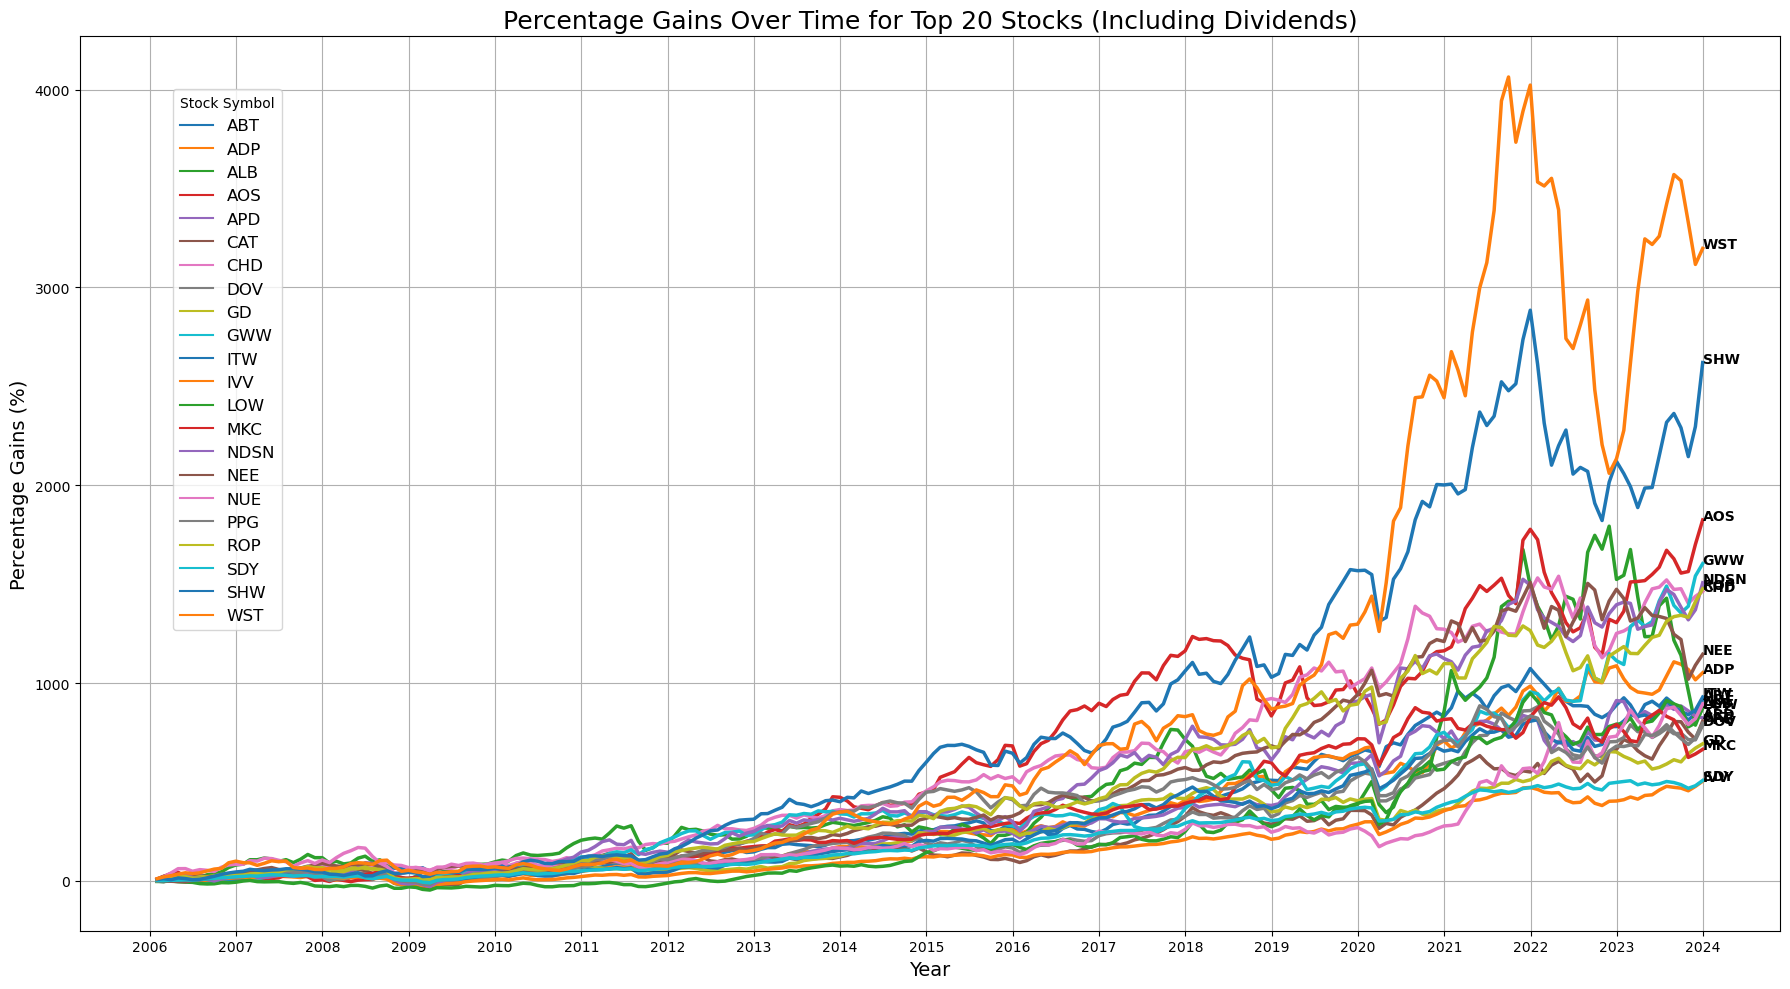

C:\Users\jonat\AppData\Local\Temp\ipykernel_12232\873728505.py:104: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  results_df.style.format({


symbol,avg_monthly_growth_rate,med_monthly_growth_rate,max_monthly_growth_rate,max_monthly_drawdown
ITW,43.89%,2.17%,8335.93%,-153.15%
AOS,26.73%,2.23%,5448.60%,-153.96%
PPG,13.92%,2.81%,1607.37%,-137.07%
NEE,5.75%,2.87%,338.71%,-65.35%
ROP,5.41%,2.60%,247.29%,-88.75%
GWW,4.82%,2.48%,246.11%,-235.22%
CHD,4.57%,1.67%,222.62%,-41.59%
APD,4.52%,2.09%,772.37%,-104.12%
CAT,4.23%,3.20%,197.01%,-164.86%
SHW,4.16%,2.31%,158.68%,-64.93%


In [57]:
# INDIVUDAL STOCKS: PERCENTAGE GAINS

#
sp_dd_da_merged_selected = pd.read_csv("sp_dd_da_merged_selected.csv")

# Step 1: Convert 'date' to datetime if not already
sp_dd_da_merged_selected['date'] = pd.to_datetime(sp_dd_da_merged_selected['date'])

#
sp_dd_da_merged_selected["dividend"] = sp_dd_da_merged_selected["dividend"].fillna(0) 

# Step 2: Normalize the starting price to 100 for each stock and accumulate dividends
def normalize_prices(df):
    
    # Normalize stock price to start from 100
    df['initial_price'] = df.groupby('symbol')['close_adjusted'].transform('first')
    df['normalized_price'] = (df['close_adjusted'] / df['initial_price']) * 100
    
    # Calculate cumulative dividends as percentage of initial price
    df['normalized_dividend'] = (df['dividend'] / df['initial_price']) * 100
    df['cumulative_dividend'] = df.groupby('symbol')['normalized_dividend'].cumsum()
    
    return df

#
normalized_df = normalize_prices(sp_dd_da_merged_selected)

# Step 3: Calculate the percentage gains including dividends
normalized_df['percentage_gains'] = normalized_df['normalized_price'] + normalized_df[
    'cumulative_dividend'] - 100
#print(normalized_df[normalized_df["symbol"] == "^GSPC"])

# Step 4: Resample the data to monthly frequency and take the mean
normalized_df.set_index('date', inplace=True)
monthly_df = normalized_df.groupby('symbol').resample('M').mean().reset_index()

# Step 5: Filter the top 10 stocks by the last month's percentage gains
last_month = monthly_df['date'].max()
ref_symbols = ["SDY", "IVV"]
top_10_symbols = monthly_df[monthly_df['date'] == last_month].nlargest(20, 'percentage_gains')[
    'symbol'].tolist() + ref_symbols

#
top_10_symbols = list(set(top_10_symbols))  # Remove duplicates
#print(top_10_symbols)
#
top_10_results = monthly_df[monthly_df['symbol'].isin(top_10_symbols)].reset_index(drop=True)
print(top_10_results)#[top_10_results["symbol"] == "SDY"])
# Plotting
plt.figure(figsize=(18, 10))
sns.lineplot(
    data=top_10_results, x='date', y='percentage_gains', hue='symbol', linewidth=2.5, palette='tab10')

# Annotate the last point of each line with the stock symbol
for symbol in top_10_symbols:
    symbol_data = top_10_results[top_10_results['symbol'] == symbol]
    last_date = symbol_data['date'].max()
    last_value = symbol_data[symbol_data['date'] == last_date]['percentage_gains'].values[0]
    plt.text(last_date, last_value, symbol, horizontalalignment=
        'left', size='medium', color='black', weight='semibold')

# Formatting the x-axis to show only years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Percentage Gains Over Time for Top 20 Stocks (Including Dividends)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage Gains (%)', fontsize=14)
plt.legend(title='Stock Symbol', loc='upper left', bbox_to_anchor=(0.05, 0.95), fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()



# Calculate the required metrics
results = []

for symbol in top_10_symbols:
    stock_data = top_10_results[top_10_results['symbol'] == symbol].copy()
    stock_data['monthly_growth'] = stock_data['percentage_gains'].pct_change() * 100  # Monthly growth rate in percentage
    stock_data['drawdown'] = stock_data['percentage_gains'].div(stock_data[
        'percentage_gains'].cummax()).sub(1).mul(100)  # Drawdown in percentage
    #print(stock_data[stock_data["symbol"] == "AOS"])
    avg_monthly_growth = stock_data['monthly_growth'].mean()
    med_monthly_growth = stock_data['monthly_growth'].median()
    max_monthly_growth = stock_data['monthly_growth'].max()
    max_monthly_drawdown = stock_data['drawdown'].min()  # Min drawdown since it's negative

    results.append({
        'symbol': symbol,
        'avg_monthly_growth_rate': avg_monthly_growth,
        'med_monthly_growth_rate': med_monthly_growth,
        'max_monthly_growth_rate': max_monthly_growth,
        'max_monthly_drawdown': max_monthly_drawdown
    })

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(["avg_monthly_growth_rate"], ascending = False)

# Display the results using pandas styling
results_df.style.format({
    'avg_monthly_growth_rate': '{:.2f}%',
    'med_monthly_growth_rate': '{:.2f}%',
    'max_monthly_growth_rate': '{:.2f}%',
    'max_monthly_drawdown': '{:.2f}%'
}).set_caption("Summary of Metrics for Top 10 Stocks").hide_index()


# Plotting
#plt.figure(figsize=(18, 10))
#sns.lineplot(
 #   data=top_10_data, x='date', y='dollar_gains', hue='symbol', linewidth=2.5, palette='tab10')

# Formatting the x-axis to show only years
#plt.gca().xaxis.set_major_locator(mdates.YearLocator())
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#plt.title('Dollar Gains Over Time for Top 10 Stocks (Including Dividends)', fontsize=18)
#plt.xlabel('Year', fontsize=14)
#plt.ylabel('Dollar Gains', fontsize=14)
#plt.legend(title='Stock Symbol', loc='upper left', bbox_to_anchor=(0.05, 0.95), fontsize=12)
#plt.grid(True)
#plt.tight_layout()
#plt.show()
#plt.close()


In [51]:
#DCS SELECTED HALFWAY: F&F Data


# Load the data
url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip'
factors_data = pd.read_csv(url, skiprows=3, index_col=0)

# Convert index to string and strip whitespace
factors_data.index = factors_data.index.astype(str).str.strip()

# Filter out non-date index entries (only keep entries with six digits representing YYYYMM format)
valid_index = factors_data.index.str.match(r'^\d{6}$')
factors_data = factors_data[valid_index]

# Define a function to parse the dates correctly
def parse_date(date_str):
    date_str = date_str.strip()
    if len(date_str) == 6:  # Format '%Y%m'
        return pd.to_datetime(date_str, format='%Y%m')
    else:
        raise ValueError(f"Unexpected date format: {date_str}")

# Apply the function to parse dates
factors_data.index = factors_data.index.map(parse_date)

# Proceed with the rest of the operations
# Extract the market returns, SMB, HML, RMW, and CMA columns
market_returns = factors_data[['Mkt-RF']]
smb = factors_data[['SMB']]
hml = factors_data[['HML']]
rmw = factors_data[['RMW']]
cma = factors_data[['CMA']]

# Define start and end year objects
start_year = 2006  # Adjust this as needed
end_year = 2023    # Adjust this as needed

# Slice the DataFrame to include data between start_year and end_year
factors_data = factors_data[(factors_data.index >= pd.to_datetime(f'{start_year}-01-01')) & 
                            (factors_data.index <= pd.to_datetime(f'{end_year}-12-31'))]

# Assign the index of the DataFrame to a new column 'year_month'
factors_data["year_month"] = factors_data.index

# Extract the year and month part from the datetime and assign it back to the 'year_month' column
factors_data['year_month'] = factors_data['year_month'].dt.to_period('M')

# Get all column names except 'year_month' to perform numeric conversion
cols = factors_data.columns.drop('year_month')

# Convert all columns except 'year_month' to numeric, coerce errors to NaN
factors_data[cols] = factors_data[cols].apply(pd.to_numeric, errors='coerce')

# Print the final DataFrame to verify the changes
#print(factors_data)

# Select the 'RF' column, rename it to 'rf', and store it in a new DataFrame 'rf'
columns=["RF", "year_month"]
rf = factors_data[columns]
#print(rf)

factors_data.to_csv("factors_data.csv")


In [52]:
# DCS SELECTED OPTIMAL: Data Cleaning

all_data_cleaned = pd.read_csv("all_data_cleaned.csv")

df = all_data_cleaned

#lst = ["^GSPC", "O", "ALB", "IVV", "SDY"]
lst = ["^GSPC", "ALB", "IVV", "SDY"]

# Create a boolean mask where True indicates rows to keep
mask = ~df['symbol'].isin(lst)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
df = df[mask]

df = df.rename(columns = {"close_adjusted": "price"})
df = df.reset_index(drop = True)

df['date'] = pd.to_datetime(df['date'])

df_all = df
#print(df.tail(50))

df.to_csv("df.csv")


In [53]:
# DCS SELECTED OPTIMAL: Performance Analysis -----------------  MONTHLY ----------------

def calculate_trades(df, symbols, buy_day = 'next', sell_day = 'next'):
    trades = []

    for symbol in symbols:
        
        # Filter dataframe for the symbol and reset index
        symbol_df = df[df['symbol'] == symbol].reset_index(drop = True)

        # Iterate through each row in the symbol's dataframe
        for index, row in symbol_df.iterrows():
            
            # Skip rows without dividend
            if pd.isna(row['dividend']):
                continue

            # Find the buy and sell dates based on buy_day and sell_day
            buy_date_index = index + buy_day if buy_day != 'next' else index + 1
            sell_date_index = index + sell_day if sell_day != 'next' else index

            # Ensure buy_date and sell_date are within the dataframe index range
            if 0 <= buy_date_index < len(symbol_df) and 0 <= sell_date_index < len(symbol_df):
                
                # Append trade details to trades list
                trade = {
                    'symbol': symbol,
                    'buy_date': symbol_df.loc[buy_date_index, 'date'],
                    'sell_date': symbol_df.loc[sell_date_index, 'date'],
                    'buy_price': symbol_df.loc[buy_date_index, 'price'],
                    'sell_price': symbol_df.loc[sell_date_index, 'price'],
                    'dividend': row['dividend']
                }
                trades.append(trade)

    # Create dataframe from trades list
    trades_df = pd.DataFrame(trades)
    
    # Calculate trade profit
    trades_df['profit'] = trades_df['sell_price'] + trades_df['dividend'] - trades_df['buy_price'] 

    
#..........................................................................................
    
    # Initialize 'Add' column with 0
    trades_df['diff_factor'] = 0

    # Calculate profit with profit/deficit from previous trade reinvested/deducted
    trades_df['diff_reinv'] = trades_df['profit'] * (1 + trades_df["diff_factor"])
    
    # Update 'diff_factor' and "diff" columns in subsequent rows
    for i in range(1, len(trades_df)):
        
        trades_df.at[i, 'diff_factor'] = trades_df.at[i - 1, 'diff_reinv'] / trades_df.at[
            i, 'buy_price']
        
        trades_df.at[i, 'diff_reinv'] = trades_df.at[i, 'profit'] * (1 + trades_df.at[
            i, 'diff_factor'])

#..........................................................................................
    #
    trades_df["diff"] = trades_df["profit"]
    
    #AGGREGATE PRE-PRE MONTH FIRST?? FX IF THERE ARE 2 TRADES IN ONE MONTH
    trades_df = trades_df.set_index('sell_date')#, inplace=True)

    # Extract year and month from the 'adjusted_date_x' column
    trades_df['year_month'] = pd.to_datetime(trades_df.index).to_period('M')
   
    # Sort by index
    trades_df = trades_df.sort_index()
    
    #print(trades_df)    
    # Group the dataframe by year and month
    trades_df = trades_df.groupby('year_month').agg(profit = (
        "profit", "sum"), diff_reinv = ("diff_reinv", "sum"), buy_price = (
        "buy_price", "mean"), diff = ("diff", "mean")).reset_index()
    #print(trades_df)
    #AGGREGATE PRE-PRE MONTH FIRST?? FX IF THERE ARE 2 TRADES IN ONE MONTH
    #trades_df = trades_df.set_index('sell_date')#, inplace=True)

    #
    trades_df["diff_perc"] = trades_df["diff"] / trades_df["buy_price"]

    # Set 'adjusted_date_x' as the index
    trades_df.set_index('year_month', inplace=True)

    # Fill missing months with most recent data point
    trades_df = trades_df.resample('M').ffill()

    # Reset index if needed
    trades_df.reset_index(inplace=True)
    
    # Extract year and month from the 'adjusted_date_x' column
    #trades_df['year_month'] = pd.to_datetime(trades_df.index).to_period('M')
    
    #print(trades_df)
    
    return trades_df

# Example usage
#symbols = lst_1 + lst_2
symbols = ["GWW"]
symbols.sort()


df = pd.read_csv("df.csv")

##############################################################################################

trades_df_monthly = calculate_trades(df, symbols, buy_day = 35, sell_day = 38)
#print(trades_df.head(50))

##############################################################################################



#print(trades_df_monthly.tail(50))

# Create a column to store the shifted profit values for comparison
trades_df_monthly['prev_profit'] = trades_df_monthly['profit'].shift(1)

# Create the adjusted_profit column
trades_df_monthly['adjusted_profit'] = trades_df_monthly.apply(
    lambda row: row['profit'] if row['profit'] != row['prev_profit'] else 0, axis=1)

# Drop the helper column
trades_df_monthly.drop(columns=['prev_profit'], inplace=True)

# Calculate the cumulative sum of profits and dividends and store it in a new column
trades_df_monthly["profits_and_dividends_acc"] = trades_df_monthly["adjusted_profit"].cumsum()

#
trades_df_monthly["percentage_gains"] = (trades_df_monthly[
    "profits_and_dividends_acc"] / trades_df_monthly["profits_and_dividends_acc"][0] * 100) - 100



# Create a column to store the shifted profit values for comparison
trades_df_monthly['prev_profit_perc'] = trades_df_monthly['diff_perc'].shift(1)

# Create the adjusted_profit column
trades_df_monthly['adjusted_profit_perc'] = trades_df_monthly.apply(
    lambda row: row['diff_perc'] if row['diff_perc'] != row['prev_profit_perc'] else 0, axis=1)

# Drop the helper column
trades_df_monthly.drop(columns=['prev_profit_perc'], inplace=True)

# Calculate the cumulative sum of profits and dividends and store it in a new column
trades_df_monthly["profits_and_dividends_acc_perc"]=trades_df_monthly["adjusted_profit_perc"].cumsum()

#
trades_df_monthly["symbol"] = "DA Selected - DCS Optimal" 

#print(trades_df_monthly.head(50))
#print(trades_df_monthly.tail(50))

#print((trades_df_monthly))
#print(monthly_df)
# Convert 'date' column to datetime
#monthly_df["year_month"] = pd.to_datetime(monthly_df["year_month"])

# Extract year and month from the 'date' column and convert to period
#monthly_df["year_month"] = monthly_df["year_month"].dt.to_period('M')

#
to_keep = ["symbol", "percentage_gains"]
to_keep_tm = ["year_month", "symbol", "profits_and_dividends_acc_perc","adjusted_profit", 
              "percentage_gains","adjusted_profit_perc"]
#print(monthly_df)
# Select specific columns
monthly_df = monthly_df[to_keep]
trades_df_monthly = trades_df_monthly[to_keep_tm]

#monthly_df = monthly_df.set_index('year_month', inplace=False)
trades_df_monthly = trades_df_monthly.set_index('year_month', inplace=False)
#print(trades_df_monthly)

trades_df_monthly.to_csv('trades_df_monthly.csv', index = True)
monthly_df.to_csv('monthly_df.csv', index = True)

#print(monthly_df)
#print(trades_df_monthly)

#gww=trades_df_monthly
#wst=trades_df_monthly
low=trades_df_monthly
#apd=trades_df_monthly

#gww.to_csv("gww_optimal.csv")
#wst.to_csv("wst_optimal.csv")
low.to_csv("low_optimal.csv")
#apd.to_csv("apd_optimal.csv")
##########################################################################################

#
sp_dd_da_merged_selected["dividend"] = sp_dd_da_merged_selected["dividend"].fillna(0) 

# Step 2: Normalize the starting price to 100 for each stock and accumulate dividends
def normalize_prices(df):
    
    # Normalize stock price to start from 100
    df['initial_price'] = df.groupby('symbol')['close_adjusted'].transform('first')
    df['normalized_price'] = (df['close_adjusted'] / df['initial_price']) * 100
    
    # Calculate cumulative dividends as percentage of initial price
    df['normalized_dividend'] = (df['dividend'] / df['initial_price']) * 100
    df['cumulative_dividend'] = df.groupby('symbol')['normalized_dividend'].cumsum()
    
    return df

#
normalized_df = normalize_prices(sp_dd_da_merged_selected)

# Step 3: Calculate the percentage gains including dividends
normalized_df['percentage_gains'] = normalized_df['normalized_price'] + normalized_df[
    'cumulative_dividend'] - 100
#print(normalized_df[normalized_df["symbol"] == "^GSPC"])
#print(normalized_df)
# Step 4: Resample the data to monthly frequency and take the mean
#normalized_df.set_index('date', inplace=True)
#monthly_df = normalized_df.groupby('symbol').resample('M').mean().reset_index()

monthly_df = normalized_df.groupby('symbol').resample('M').mean().reset_index()
#print(monthly_df)
##########################################################################################

    #dollar_gains.index = dollar_gains.index.to_timestamp()
    
    # Ensure 'adjusted_date_x' is a datetime column
    #trades_df['year_month'] = pd.to_datetime(trades_df['year_month'])


In [54]:
# DCS ALL: Preliminary Analysis of Aggregate Profits per Stock per Trading Day

# First, let's identify the unique symbols
unique_symbols = df['symbol'].unique()

# Find the maximum number of days between dividend dates across all symbols
max_days_between_dividends = 0
for symbol in unique_symbols:
    symbol_df = df[df['symbol'] == symbol]
    dividend_indices = symbol_df.index[symbol_df['dividend'].notnull()].tolist()
    for i in range(len(dividend_indices) - 1):
        days_between = dividend_indices[i + 1] - dividend_indices[i]
        if days_between > max_days_between_dividends:
            max_days_between_dividends = days_between

#----------------------------------------------------------------------------------------

# Initialize an empty dictionary to store the results
result_dict = {}

# Iterate over unique symbols in the DataFrame
for symbol in df['symbol'].unique():
    indices = []
    dividend_dates = df[(df['symbol'] == symbol) & ( ~ df['dividend'].isna())].index.tolist()
    result_dict[symbol] = dividend_dates

#----------------------------------------------------------------------------------------

# Initialize a dictionary to store row differences for each symbol
all_row_differences = {}

# Iterate through the result_dict dictionary
for symbol, indices in result_dict.items():
    
    # Calculate the row differences between consecutive dividend indices
    row_differences = [indices[i] - indices[i - 1] for i in range(1, len(indices))]
    all_row_differences[symbol] = row_differences

#----------------------------------------------------------------------------------------

# Initialize an empty DataFrame with symbols as rows and days between dividend dates as columns
result_df = pd.DataFrame(index = result_dict.keys(), columns = range(max_days_between_dividends))

# Iterate through the result_dict dictionary
for symbol, indices in result_dict.items():
    
    # Iterate through dividend indices
    for i in range(len(indices) - 1):
        
        # Calculate the mean price for each normalized day between consecutive dividend dates
        start_index = indices[i] + 1
        end_index = indices[i + 1]
        num_days = end_index - start_index
        
        for j in range(num_days):
            normalized_day_index = start_index + j
            mean_price = df.loc[normalized_day_index, 'price']
            
            # Fill the corresponding cell in result_df with mean_price
            result_df.at[symbol, j] = mean_price


C:\Users\jonat\AppData\Local\Temp\ipykernel_12232\2370617991.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_12232\2370617991.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_12232\2370617991.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_12232\2370617991.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_12232\237061

   Symbol  P-value (Constant)  R-squared  Constant Coefficient
15    SHW            0.684434   0.012060              0.013761
10    MKC            0.776735   0.009909              0.003048
12    NUE            0.779675   0.009041              0.006342
18    WST            0.784432   0.013316              0.012739
3     ADP            0.794193   0.008093              0.006829
8     ITW            0.815017   0.015329             -0.006155
13    PPG            0.823955   0.012645              0.004603
16    GWW            0.835071   0.011997              0.015173
17    NEE            0.842906   0.007925              0.001904
1     AOS            0.847344   0.013959              0.001837
4     CAT            0.859761   0.016822              0.005604
2     APD            0.880981   0.014388             -0.005451
5     CHD            0.884927   0.016099             -0.001505
9     LOW            0.929011   0.015282              0.002332
11   NDSN            0.931537   0.012605              0

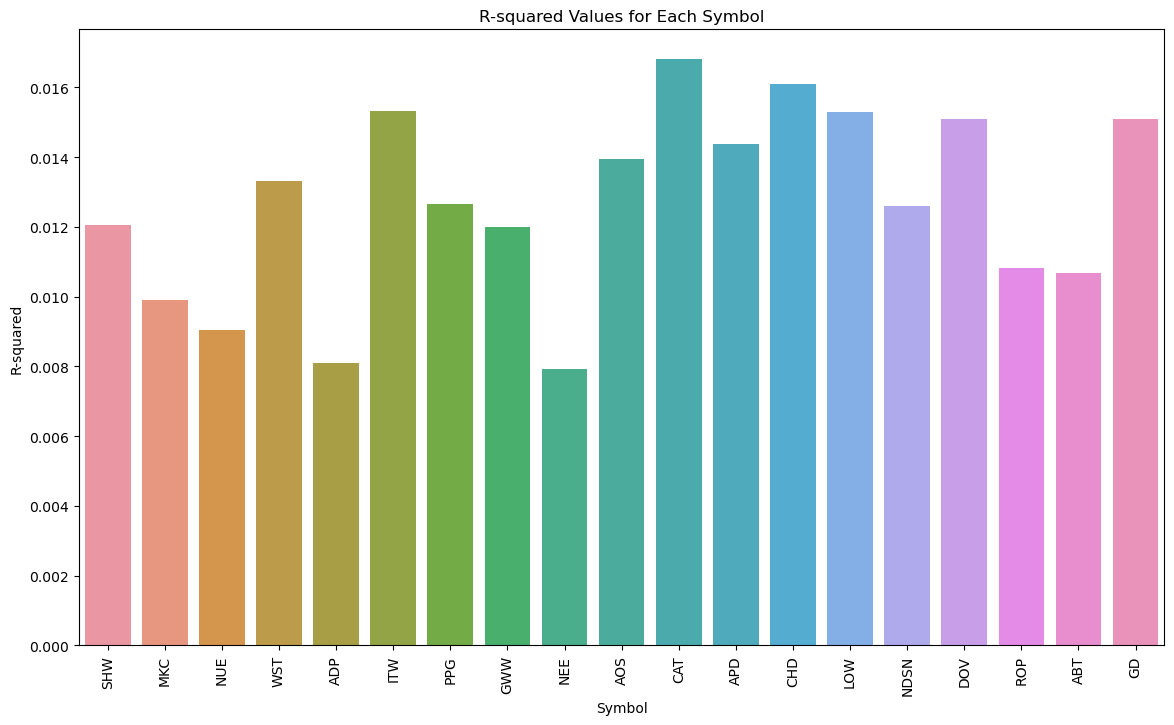

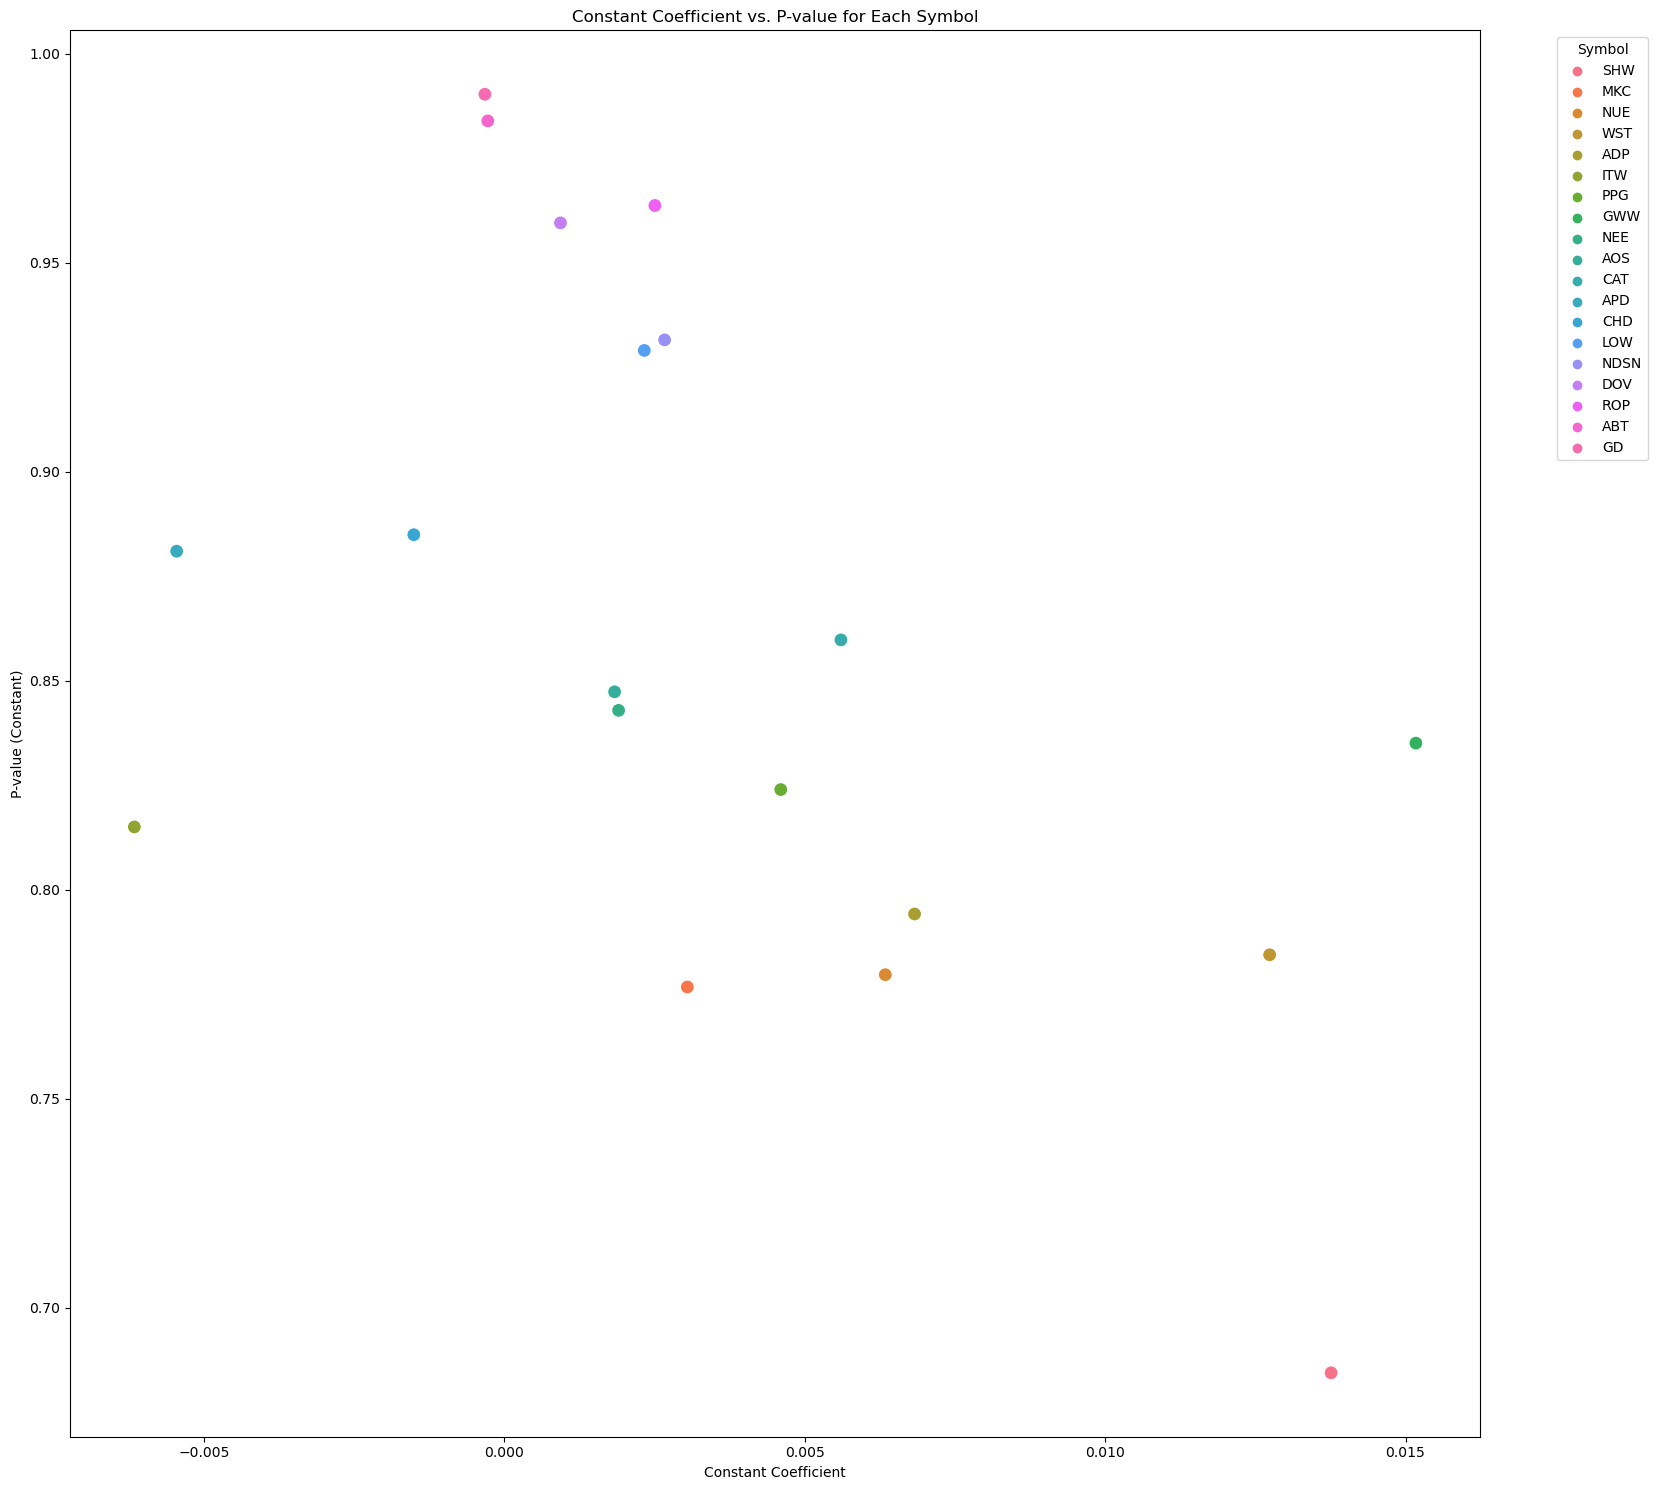

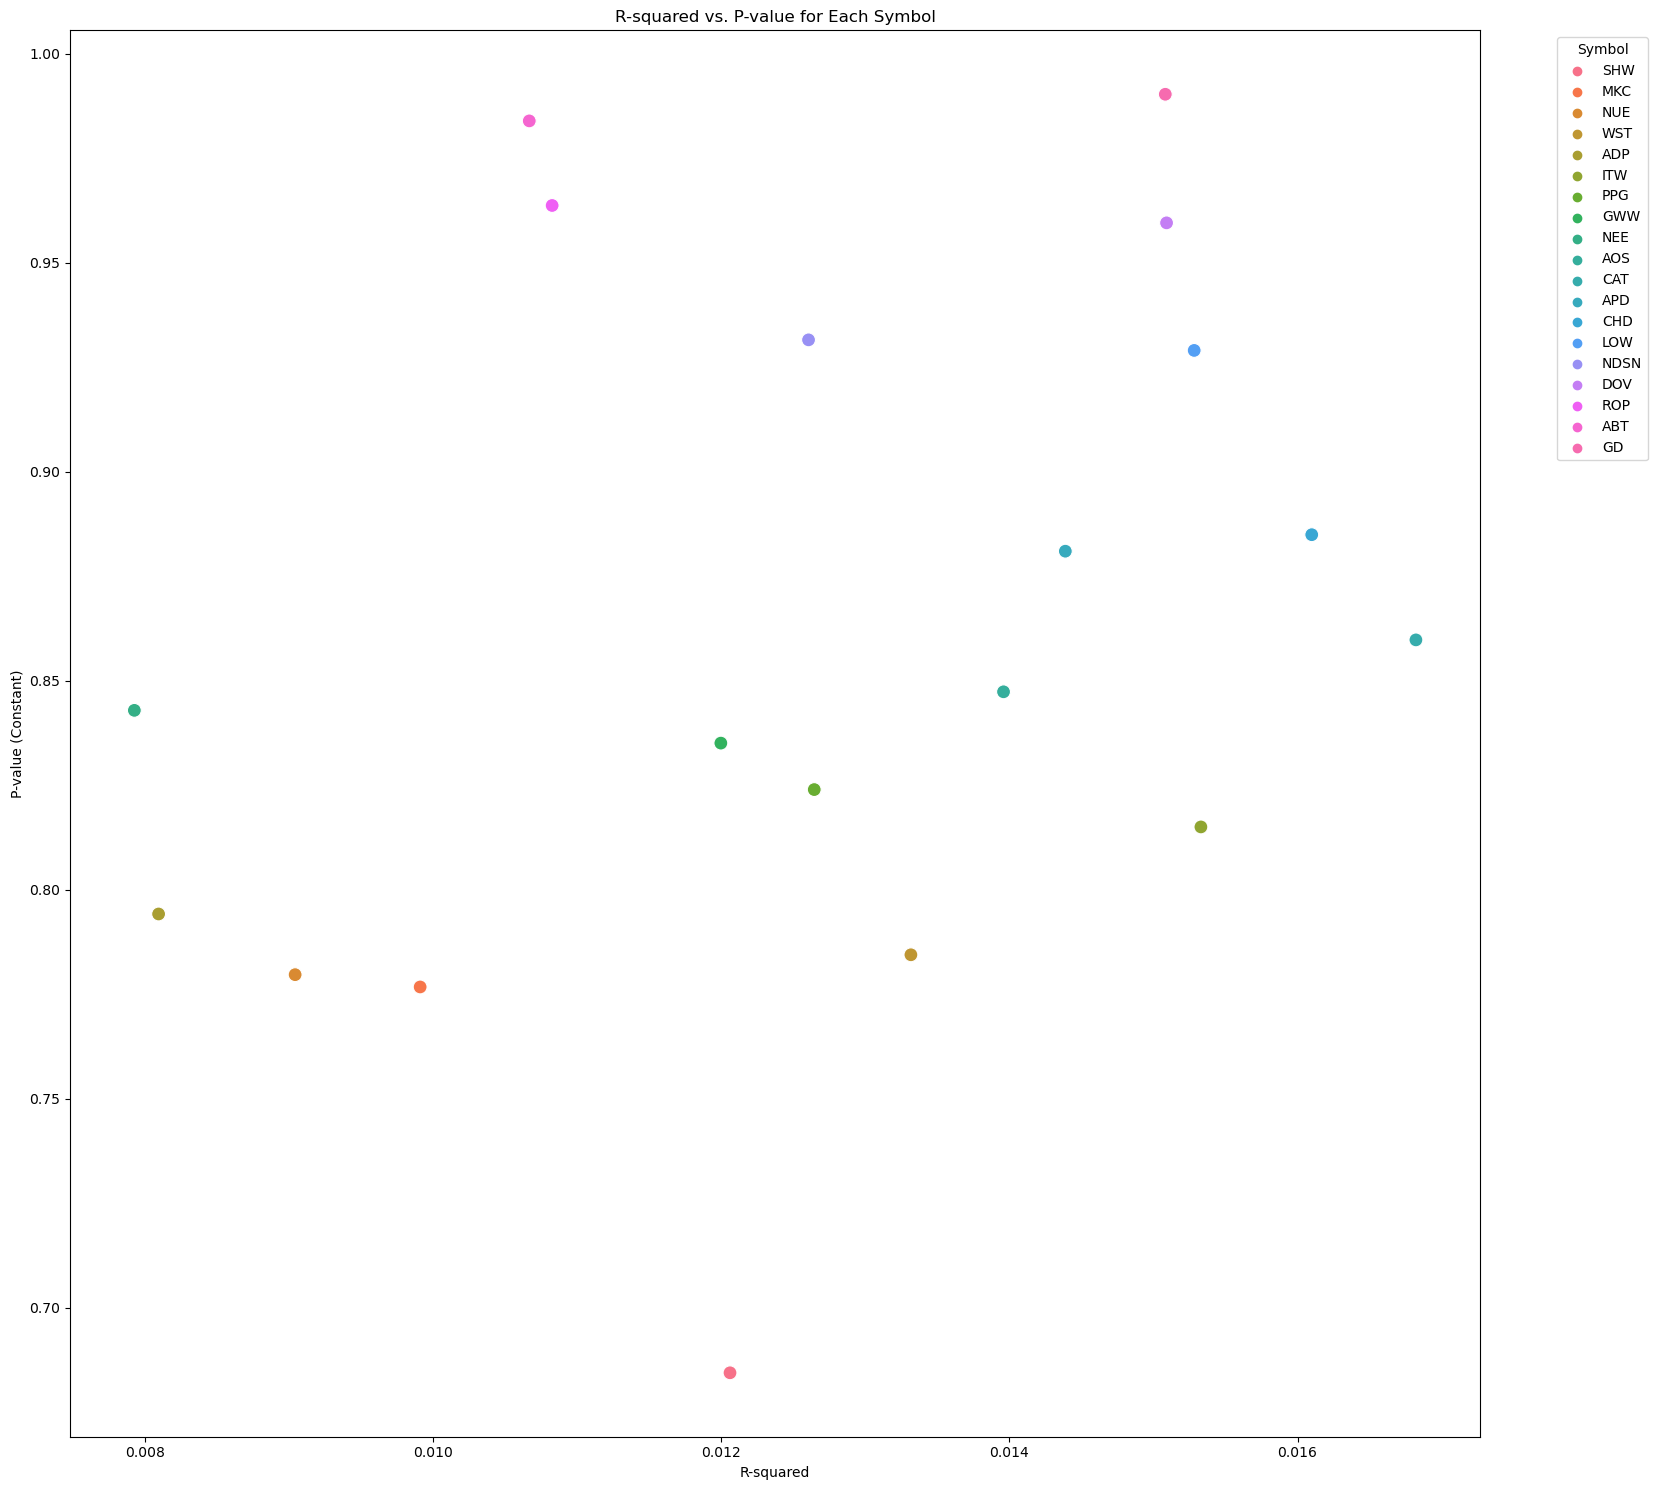

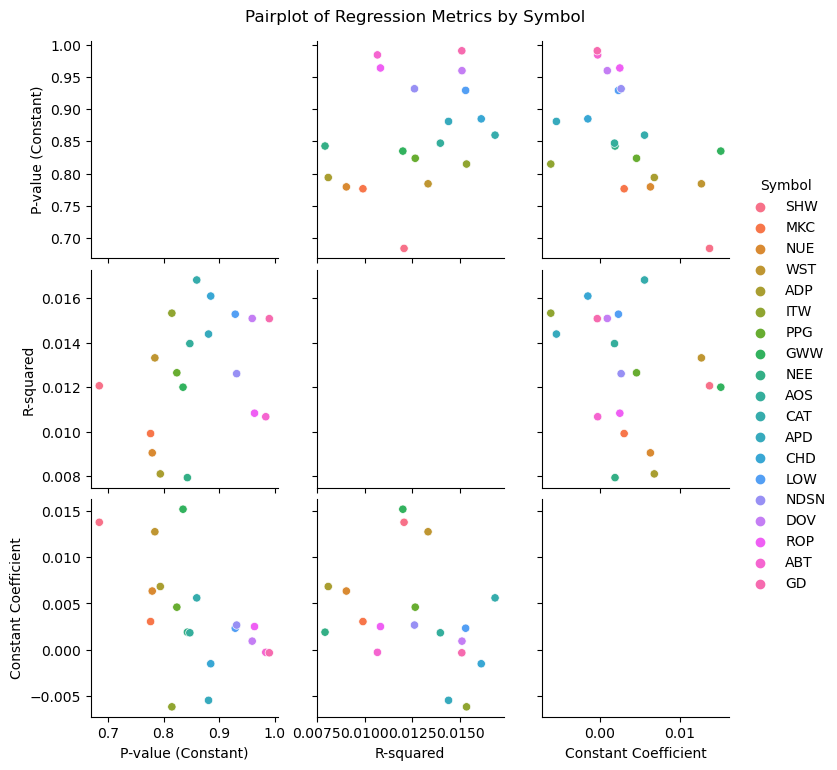

In [55]:
#########################################################################################
################################################


# DCS SELECTED OPTIMAL: Regression Analysis

# Define a function to calculate trading gains around dividend dates
def calculate_trading_gains(df_all, window_size = 61):
    trading_gains = []
    for symbol, group in df_all.groupby('symbol'):
        group['price_diff'] = group['price'].diff()
        group['dividend_effect'] = group['price_diff'].rolling(window = window_size).sum()
        trading_gains.append(group)

    return pd.concat(trading_gains)

# Filter the DataFrame to include only the selected symbols

symbols_regr = ['LOW', 'WST', 'ABT', 'NEE', 'APD', 'AOS', 'NDSN', 'GD','CAT', 'PPG', 
                'NUE', 'SHW', 'DOV', 'GWW', 'ROP', 'CHD', 'ALB', 'ADP', 'MKC',"ITW","SDY","IVV"]

# Filter the DataFrame to keep only the rows where 'symbol' matches any value in 'symbols_regr'
df_filtered = df_all[df_all['symbol'].isin(symbols_regr)]

# Initialize lists to store results for each symbol
p_values = []
r_squared_values = []
constant_coefficients = []

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Symbol': [],  # Empty lists for now
    'P-value (Constant)': [],
    'R-squared': [],
    'Constant Coefficient': []
})

# Loop through each symbol
for symbol in df_filtered["symbol"].unique():  # Use unique() to iterate only over unique symbols

    # Filter the DataFrame for the current symbol
    df_symbol = df_filtered[df_filtered['symbol'] == symbol]
    df_symbol.reset_index(drop = True, inplace = True)  # Reset index to ensure proper indexing
    
    # Calculate trading gains around dividend dates with a window size of 61 days
    df_symbol = calculate_trading_gains(df_symbol, window_size = 61)
    
    # Prepare the data for regression analysis
    X = df_symbol['dividend_effect'].shift(-1)  # Independent variable: 
    #Price change after dividend date
    y = df_symbol['price_diff'].shift(-1)  # Dependent variable: Price change around dividend date

    # Drop rows with missing values, but ensure consistency in indices
    valid_indices = X.dropna().index.intersection(y.dropna().index)
    X = X.loc[valid_indices]
    y = y.loc[valid_indices]

    # Add a constant to the independent variable for the intercept term
    X = sm.add_constant(X)

    # Ensure X and y have the same length
    if len(X) != len(y):
        print(f"Skipping symbol {symbol} due to mismatched lengths.")
        continue

    # Fit a linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Append results to the DataFrame
    results_df = results_df.append({
        'Symbol': symbol,
        'P-value (Constant)': results.pvalues[0],  # P-value for the constant term
        'R-squared': results.rsquared,  # R-squared value
        'Constant Coefficient': results.params[0]  # Coefficient for the constant term
    }, ignore_index = True)

# Reset index of the results DataFrame
results_df.reset_index(drop = True, inplace = True)

# Sort result by "P-value (Constant)"
results_df.sort_values(by = ['P-value (Constant)'], inplace = True)

print(results_df)

# Visualization

# Bar Plot of R-squared Values
plt.figure(figsize=(14, 8))
sns.barplot(x='Symbol', y='R-squared', data=results_df)
plt.title('R-squared Values for Each Symbol')
plt.xlabel('Symbol')
plt.ylabel('R-squared')
plt.xticks(rotation=90)
plt.show()
plt.close()

# Scatter Plot of Constant Coefficient vs. P-value
plt.figure(figsize=(15, 15))
sns.scatterplot(x='Constant Coefficient', y='P-value (Constant)', data=results_df, hue='Symbol', s=100)
plt.title('Constant Coefficient vs. P-value for Each Symbol')
plt.xlabel('Constant Coefficient')
plt.ylabel('P-value (Constant)')
plt.tight_layout() 
plt.legend(title='Symbol', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
plt.close()


# Additional Plots for deeper analysis

# Scatter Plot of R-squared vs. P-value
plt.figure(figsize=(15, 15))
sns.scatterplot(x='R-squared', y='P-value (Constant)', data=results_df, hue='Symbol', s=100)
plt.title('R-squared vs. P-value for Each Symbol')
plt.xlabel('R-squared')
plt.ylabel('P-value (Constant)')
plt.tight_layout() 
plt.legend(title='Symbol', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
plt.close()

# Pairplot to show relationships between all metrics
sns.pairplot(results_df, hue='Symbol')
plt.suptitle('Pairplot of Regression Metrics by Symbol', y=1.02)
plt.show()
plt.close()


In [56]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

all_data_ml = pd.read_csv("all_data_ml.csv")

# Rename and remove columns
all_data_ml = all_data_ml.rename(columns = {
    "Symbol": "symbol", "Date": "date", "dividend": "dividend_yield", "Close": "close",
    "Open": "open", "High": "high", "Low": "low", "Volume": "volume"})

# Assuming df_all is your DataFrame containing stock price data and dividend dates
all_data_ml = df_all

# Ensure the 'date' column is in datetime format
df_all['date'] = pd.to_datetime(df_all['date'])

# Create additional features if needed
df_all['day_of_week'] = df_all['date'].dt.dayofweek
df_all['day_of_month'] = df_all['date'].dt.day
df_all['week_of_year'] = df_all['date'].dt.isocalendar().week
df_all['month'] = df_all['date'].dt.month
df_all['quarter'] = df_all['date'].dt.quarter

# Example additional variables could be technical indicators or other market data
# Here we assume 'price' is the target variable and 'dividend_yield' is an additional feature
features = ['open', 'high', 'low', 'close', 'volume', 'dividend_yield', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter']
target = 'close_adjusted'

# Filter the DataFrame to include only relevant columns
df_all_filtered = df_all[features + [target]]

# Assuming df_all_filtered is your DataFrame and 'dividend_yield' is a column in it
df_all_filtered['dividend_yield'].fillna(0, inplace=True)

# Train Random Forest model
X = df_all_filtered[features]
y = df_all_filtered[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)



KeyError: "['open', 'high', 'low', 'close', 'volume', 'dividend_yield', 'close_adjusted'] not in index"

In [ ]:
# Assuming rf_reg is your trained Random Forest model and X_train is your training data

# Get feature importances
feature_importances = rf_reg.feature_importances_

# Get sorted indices of feature importances
sorted_indices = np.argsort(feature_importances)[::-1]

# Print feature importance ranking
print("Feature Importance Ranking:")
for i, idx in enumerate(sorted_indices):
    print(f"{i+1}. Feature: {X_train.columns[idx]}, Importance: {feature_importances[idx]}")

# Plot feature importances (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), X_train.columns[sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()
plt.close()


In [ ]:
# Assuming df is your historical data DataFrame containing relevant columns (including features and target)

df = df_all_filtered

# Make predictions
df_all_filtered['predicted_target'] = rf_reg.predict(df_all_filtered[features])

# Calculate actual returns
df_all_filtered['actual_returns'] = df_all_filtered['close'].pct_change() * 100
df_all_filtered['actual_returns'].fillna(0, inplace=True)

# Define trading signals based on predicted outcomes
threshold_upper = df_all_filtered['predicted_target'].quantile(0.75)
threshold_lower = df_all_filtered['predicted_target'].quantile(0.25)
df_all_filtered['signal'] = np.where(df_all_filtered['predicted_target'] > threshold_upper, 1,
                                     np.where(df_all_filtered['predicted_target'] < threshold_lower, -1, 0))

# Calculate daily returns based on trading signals
df_all_filtered['daily_returns'] = df_all_filtered['signal'] * df_all_filtered['actual_returns']

# Handle cumulative returns
df_all_filtered['cumulative_returns'] = (1 + df_all_filtered['daily_returns'] / 100).cumprod()
df_all_filtered['cumulative_returns'] = df_all_filtered['cumulative_returns'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Cap excessive growth in cumulative returns
max_cum_return = df_all_filtered['cumulative_returns'].quantile(0.99)
df_all_filtered['cumulative_returns'] = df_all_filtered['cumulative_returns'].clip(upper=max_cum_return)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(df_all_filtered.index, df_all_filtered['cumulative_returns'], label='Cumulative Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Dividend Capture Strategy')
plt.legend()
plt.grid(True)
plt.show()

plt.close()


In [ ]:
# DCS ALL: Clean Prel. Analysis and Normalize Values

# Drop outlier columns
result_df = result_df.drop(result_df.columns[62:121], axis = 1)

from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

all_data_ml = pd.read_csv("all_data_ml.csv")

# Rename and remove columns
all_data_ml = all_data_ml.rename(columns = {
    "Symbol": "symbol", "Date": "date", "Close": "close","Open": "open", "High": "high",
    "Low": "low", "Volume": "volume","close_adjusted":"adjusted_close"})
#print(all_data_ml)
# Ensure the 'date' column is in datetime format
all_data_ml['date'] = pd.to_datetime(all_data_ml['date'])

gww = all_data_ml[all_data_ml["symbol"] == "GWW"]
gd = all_data_ml[all_data_ml["symbol"] == "GD"]
aos = all_data_ml[all_data_ml["symbol"] == "AOS"]
chd = all_data_ml[all_data_ml["symbol"] == "CHD"]



# Function to create features and calculate returns
def create_features_and_returns(df):
    df['return'] = df['adjusted_close'].pct_change()
    df['volatility'] = df['adjusted_close'].rolling(window=10).std()
    df['momentum'] = df['adjusted_close'].rolling(window=10).mean()
    df['volume_change'] = df['volume'].pct_change()
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year

    # Create a column to mark the buying and selling dates
    df['buy_signal'] = np.where(df['dividend'].shift(-1) > 0, 1, 0)
    df['sell_signal'] = np.where(df['dividend'].shift(-52) > 0, 1, 0)
    
    # Calculate strategy returns
    df['strategy_return'] = 0
    for i in range(len(df) - 52):
        if df['buy_signal'].iloc[i] == 1:
            buy_price = df['adjusted_close'].iloc[i + 1]
            sell_price = df['adjusted_close'].iloc[i + 52]
            df['strategy_return'].iloc[i + 52] = (sell_price - buy_price) / buy_price

    df.fillna(0, inplace=True)
    return df

# Apply the function to each stock DataFrame
gww = create_features_and_returns(gww)
gd = create_features_and_returns(gd)
aos = create_features_and_returns(aos)
chd = create_features_and_returns(chd)
#print(chd.describe())
# Replace inf and -inf with NaN in the volume_change column
chd['volume_change'] = chd['volume_change'].replace([np.inf, -np.inf], np.nan)

# Replace NaN values with 0 in the volume_change column
chd['volume_change'] = chd['volume_change'].fillna(0)


# Combine data from all stocks
all_data = pd.concat([gww, gd, aos, chd])

# Replace inf and -inf with NaN in the volume_change column
all_data['volume_change'] = all_data['volume_change'].replace([np.inf, -np.inf], np.nan)

# Replace NaN values with 0 in the volume_change column
all_data['volume_change'] = all_data['volume_change'].fillna(0)

# Debugging: Print sample data to check signals
#print(all_data[[
    #'date', 'symbol', 'adjusted_close', 'buy_signal', 'sell_signal', 'strategy_return']].head(50))
#chd_tjek = all_data[all_data["symbol"]=="chd"]
#print(chd_tjek.describe())
# Define features and target
features = ['adjusted_close', 'return', 'volatility', 'momentum', 'volume_change', 
            'day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter', 'year']
target = 'strategy_return'

# Split the data into training and testing sets
X = all_data[features]
y = all_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')



# Implement the trading strategy based on predictions
def execute_strategy(df, model):
    df['predicted_return'] = model.predict(df[features])
    df['signal'] = np.where(df['predicted_return'] > 0, 1, -1)  # Buy if predicted return is positive, otherwise sell
    df['strategy_return'] = df['signal'] * df['return']
    df['cumulative_return'] = (1 + df['strategy_return']).cumprod() - 1
    
    return df

# Apply the strategy to each stock
gww_strategy = execute_strategy(gww, model)
gd_strategy = execute_strategy(gd, model)
aos_strategy = execute_strategy(aos, model)
chd_strategy = execute_strategy(chd, model)
print(chd_strategy)
# Combine strategy returns
# Assuming your dataframes have a 'date' column
combined_returns = pd.concat([gww_strategy.set_index('date')['cumulative_return'],
                              gd_strategy.set_index('date')['cumulative_return'],
                              aos_strategy.set_index('date')['cumulative_return'],
                              chd_strategy.set_index('date')['cumulative_return']], axis=1)

combined_returns.columns = ['GWW', 'GD', 'AOS', 'CHD']
#print(combined_returns)
# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(combined_returns.index, combined_returns['GWW'], label='GWW')
plt.plot(combined_returns.index, combined_returns['GD'], label='GD')
plt.plot(combined_returns.index, combined_returns['AOS'], label='AOS')
plt.plot(combined_returns.index, combined_returns['CHD'], label='CHD')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Dividend Capture Strategy')
plt.legend()
plt.grid(True)
plt.show()
plt.close()







###################################################################################
###################################################################################
###################################################################################

In [ ]:
# DCS ALL: Linear Regression Analysis

# Select the first 62 columns from the DataFrame
columns = normalized_df.columns[0:62]

# Reshape the DataFrame from wide format to long format
# 'index' is used as the identifier variable
# 'columns' are used as the value variables
normalized_df_melt = pd.melt(normalized_df.reset_index(), id_vars = 'index', value_vars = columns)

# Convert 'delta' and 'days_after_ex_dividend' columns to numeric dtype
normalized_df_melt['value'] = pd.to_numeric(normalized_df_melt['value'])
normalized_df_melt['variable'] = pd.to_numeric(normalized_df_melt['variable'])

# Perform regression analysis
X = sm.add_constant(normalized_df_melt['variable'])
model = sm.OLS(normalized_df_melt['value'], X)
results = model.fit()

# Plot regression line
plt.figure(figsize=(14, 8))
plt.scatter(normalized_df_melt['variable'], normalized_df_melt['value'], alpha=0.5, s=10)
plt.plot(normalized_df_melt['variable'], results.predict(X), color='red', linewidth=2)
plt.xlabel('Normalized Days Dividend Dates')
plt.ylabel('Normalized Price')
plt.title('Regression Analysis of Price Deltas')
plt.grid(True)
plt.xticks(np.arange(0, 101, step = 5))  # Adjust step size as needed
plt.locator_params(axis = 'x', tight=True)
plt.show()
plt.close()

"""
R-squared: The R-squared value is 0.055, which means that approximately 5.5% of the variability in the dependent 
variable (value) is explained by the independent variable (variable). This indicates a relatively weak relationship 
between the two variables.

F-statistic: The F-statistic is 196.5 with a very low p-value (1.90e-43), indicating that the overall regression model 
is statistically significant. This suggests that the independent variable (variable) has a statistically significant 
effect on the dependent variable (value).

Coefficient interpretation:

The coefficient for the constant term (const) is 111.6258. This represents the estimated value of the dependent variable 
(value) when the independent variable (variable) is zero. In this case, it likely represents the intercept of the 
regression line.
The coefficient for the variable (variable) is -0.0847. This represents the estimated change in the dependent variable 
(value) for a one-unit increase in the independent variable (variable), holding all other variables constant. 
Since the coefficient is negative, it suggests that there is a negative relationship between the independent variable 
and the dependent variable.

P-values: Both coefficients have p-values less than 0.05, indicating that they are statistically significant at the 
95% confidence level. This suggests that both the constant term and the independent variable have a significant effect 
on the dependent variable.

Omnibus and Jarque-Bera tests: These tests assess the normality of the residuals. The p-values for both tests are very 
low (close to 0), indicating that the residuals are not normally distributed. 
This suggests that the assumption of normality may be violated.

Durbin-Watson: The Durbin-Watson statistic is 2.140, which is close to 2. This suggests that there is little or no 
autocorrelation in the residuals.

Cond. No.: The condition number measures multicollinearity. A value greater than 30 indicates potential multicollinearity 
issues. In this case, the condition number is 69.9, suggesting moderate multicollinearity.

Overall, the regression model suggests that the independent variable (variable) has a statistically significant, 
albeit weak, negative effect on the dependent variable (value). However, it's important to consider the limitations 
of the model, such as the low R-squared value and potential violations of assumptions.
"""


In [ ]:
# DCS ALL: Non-Linear Regression Analysis

from scipy.optimize import curve_fit

# Define a non-linear function to fit to the data
def nonlinear_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Extract x and y values for the regression analysis
x_values = np.arange(len(normalized_df.columns))  # Use column indices as x values
y_values = normalized_df.mean(axis = 0).values     # Take the mean of each column as y values

# Provide initial guesses for the parameters
initial_guess = (1, 0.01, 1)

# Fit the non-linear function to the data
popt, pcov = curve_fit(nonlinear_func, x_values, y_values, p0 = initial_guess)

# Generate y values using the fitted function
fitted_y_values = nonlinear_func(x_values, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, label='Original Data')
plt.plot(x_values, fitted_y_values, 'r-', label='Fitted Curve')
plt.title('Non-linear Regression Analysis')
plt.xlabel('Normalized Day')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()
plt.close()


In [ ]:
# All strategies: Performance Analysis ----------------- MONTHLY ----------------- 

sp_dd_da_merged_selected = pd.read_csv("sp_dd_da_merged_selected.csv")

def bh_perf_analysis(portfolio):
    
    sp_dd_da_merged_selected = portfolio

    # Convert to datetime format
    sp_dd_da_merged_selected['date'] = pd.to_datetime(sp_dd_da_merged_selected['date'])
    sp_dd_da_merged_selected['year_month'] = sp_dd_da_merged_selected['date'].dt.to_period('M')

    # Group by symbol and month, and calculate monthly sums for dividends
    sp_dd_da_merged_selected_dividend = sp_dd_da_merged_selected.groupby(['symbol', 'year_month'])[
        'dividend'].agg('sum') 
        
    # Convert to dataframe and reset index
    sp_dd_da_merged_selected_dividend = pd.DataFrame(sp_dd_da_merged_selected_dividend)
    sp_dd_da_merged_selected_dividend.reset_index(inplace=True)

    # Retrieve minimum and maximum dates within each symbol for each month
    grouped_dates_min = sp_dd_da_merged_selected.groupby(['symbol', 'year_month'])[
        'date'].min().reset_index()
    grouped_dates_max = sp_dd_da_merged_selected.groupby(['symbol', 'year_month'])[
        'date'].max().reset_index()

    # Merge dataframes to retrieve prices on first and last dates of each month for each symbol
    grouped_dates_min = pd.merge(grouped_dates_min, sp_dd_da_merged_selected, on=[
        'symbol', 'date'], how='inner')
    grouped_dates_min = grouped_dates_min.rename(columns={"close_adjusted": "price_primo"})

    grouped_dates_max = pd.merge(grouped_dates_max, sp_dd_da_merged_selected, on=[
        'symbol', 'date'], how='inner')
    grouped_dates_max = grouped_dates_max.rename(columns={"close_adjusted": "price_ultimo"})

    # Remove unnecessary columns
    remove = ["dividend", "date", "symbol", "year_month"]
    grouped_dates_min = grouped_dates_min[grouped_dates_min.columns.difference(remove)] 
    grouped_dates_max = grouped_dates_max[grouped_dates_max.columns.difference(remove)]

    # Concatenate dataframes with first and last dates of each month for each symbol
    grouped_dates_final = pd.concat([
        grouped_dates_min, grouped_dates_max, sp_dd_da_merged_selected_dividend], axis=1)
    #print(grouped_dates_final)
    # Replace NaN's with 0's to ensure correct calculations 
    grouped_dates_final["dividend"] = grouped_dates_final["dividend"].fillna(0)
    
    # Calculate delta between price end of month and beginning of month
    grouped_dates_final["diff"] = grouped_dates_final["price_ultimo"] + grouped_dates_final[
        "dividend"] - grouped_dates_final["price_primo"]

    # Sort the DataFrame by the 'date' column
    grouped_dates_final.sort_values(by=["symbol", 'year_month'], inplace=True)
    #print(grouped_dates_final)
    # Group data columns by month
    grouped_dates_final = grouped_dates_final.groupby(grouped_dates_final["year_month"]).agg(
        price_primo=("price_primo", "mean"), price_ultimo=("price_ultimo", "mean"), 
        dividend=("dividend", "mean"), diff=("diff", "mean"),profit=("diff", "sum")).reset_index()
    #print(grouped_dates_final)
    # Calculate percentual difference between price end of month and beginning of month
    grouped_dates_final["diff_perc"] = (grouped_dates_final["price_ultimo"] + grouped_dates_final[
        "dividend"] - grouped_dates_final["price_primo"]) / grouped_dates_final["price_primo"]  
    
    # Remove unnecessary columns
    remove = ["price_primo", "price_ultimo", "dividend"]
    grouped_dates_final = grouped_dates_final[grouped_dates_final.columns.difference(remove)] 

    return grouped_dates_final


# Example usage of the function
# Assuming 'portfolio' is your DataFrame with daily price data
# result_daily = bh_perf_analysis(portfolio)
#print(sp_dd_da_merged_selected)
#print(result_daily)
#print(final)

remove=["year_month"]

# DCS OPTIMAL
# Select and rename specific columns related to DCS Optimal calculation
#selected_columns = ['profit', "diff_perc", "diff_reinv", "diff_perc_reinv"]
trades_df_monthly=pd.read_csv("trades_df_monthly.csv")
print(trades_df_monthly)


#Convert 'year_month' to Period dtype
trades_df_monthly['year_month'] = pd.PeriodIndex(trades_df_monthly['year_month'], freq='M')

#
trades_df_monthly = trades_df_monthly.set_index(["year_month"])
selected_columns = ['adjusted_profit', "percentage_gains", "adjusted_profit_perc"]
dcs_optimal = trades_df_monthly[selected_columns]
dcs_optimal = dcs_optimal.rename(columns = {
    "percentage_gains": "DA Selected - DCS Optimalperc",
    "adjusted_profit": "DA Selected - DCS Optimaldollar",
    "adjusted_profit_perc": "DA Selected - DCS Optimalperc_adj"})
#dcs_optimal["year_month"] = dcs_optimal.index
#dcs_optimal["year_month"] = dcs_optimal["year_month"].dt.to_period("M")

#print(dcs_optimal)

#profits_and_dividends_acc  

# DCS HALFWAY
# Calculate DCS (Dividend Capture Strategy) halfway dollar value

#print(final_monthly)
# Select and rename specific columns related to DCS halfway calculation
final_monthly=pd.read_csv("final_monthly.csv")
selected_columns = ['adjusted_profit', "year_month", "percentage_gains","adjusted_profit_perc"]
#adjusted_profit  profits_and_dividends_acc
dcs_halfway = final_monthly[selected_columns]
dcs_halfway = dcs_halfway.rename(
    columns = {"percentage_gains": "DA Selected - DCS Halfwayperc", 
               "adjusted_profit": "DA Selected - DCS Halfwaydollar",
               "adjusted_profit_perc": "DA Selected - DCS Halfwayperc_adj"})

#Convert 'year_month' to Period dtype
dcs_halfway['year_month'] = pd.PeriodIndex(dcs_halfway['year_month'], freq='M')

dcs_halfway = dcs_halfway.set_index(["year_month"])
#print(dcs_halfway)


# RISK-FREE RATE
# Reset the index of the 'rf' DataFrame and drop the old index
#rf = rf.reset_index(drop=True)

# Convert the risk-free rate to a percentage
rf_calc = rf
rf_calc["RF"] = (rf_calc["RF"] / 10)
rf_calc["RF"] = rf_calc["RF"].astype(float)

#Convert 'year_month' to Period dtype
rf_calc['year_month'] = pd.PeriodIndex(rf_calc['year_month'], freq='M')

rf_calc = rf_calc.set_index(["year_month"])



#
all_data_cleaned=pd.read_csv("all_data_cleaned.csv")
all_data_cleaned["date"] = pd.to_datetime(all_data_cleaned["date"])
all_data_cleaned["year_month"] = all_data_cleaned["date"]

#Convert 'year_month' to Period dtype
all_data_cleaned['year_month'] = pd.PeriodIndex(all_data_cleaned['year_month'], freq='M')

#print(all_data_cleaned)



# BUY AND HOLD (B&H) SELECTED
# Filter 'all_data_cleaned' to include only symbols in 'bh_selected_portfolio'
bh_selected = all_data_cleaned 
bh_selected_portfolio = lst_1 + lst_2
bh_selected = bh_selected[bh_selected["symbol"].isin(bh_selected_portfolio)]
#print(bh_selected)
# Perform performance analysis on the selected B&H portfolio
bh_perf_selected_final = bh_perf_analysis(bh_selected)

# Remove 'dividend' column and rename relevant columns
#bh_perf_selected_final = bh_perf_selected_final[bh_perf_selected_final.columns.difference(remove)]
#print(bh_perf_selected_final.head(50))
bh_perf_selected_final = bh_perf_selected_final.rename(columns = {
    "diff": "DA Selected - B&Hdollar"})
bh_perf_selected_final = bh_perf_selected_final.rename(columns = {
    "diff_perc": "DA Selected - B&Hperc"})
bh_perf_selected_final = bh_perf_selected_final.set_index(["year_month"])
#print(bh_perf_selected_final)


# BUY AND HOLD (B&H) ALL / DCS ALL
# Filter 'all_data_cleaned' to include all symbols in 'da' DataFrame
bh_all = all_data_cleaned
bh_all = bh_all[bh_all["symbol"] == "SDY"]
#bh_all_portfolio = da["symbol"].tolist()
#bh_all = bh_all[bh_all["symbol"].isin(bh_all_portfolio)]

# Perform performance analysis on the B&H all portfolio
bh_perf_all_final = bh_perf_analysis(bh_all)

# Remove 'dividend' column and rename relevant columns
#bh_perf_all_final = bh_perf_all_final[bh_perf_all_final.columns.difference(remove)]
bh_perf_all_final = bh_perf_all_final.rename(columns = {"diff": "DA ALL - B&H (SDY)dollar"})
bh_perf_all_final = bh_perf_all_final.rename(columns = {"diff_perc": "DA ALL - B&H (SDY)perc"})
bh_perf_all_final = bh_perf_all_final.set_index(["year_month"])
#print(bh_perf_all_final)


# S&P 500
# Filter 'all_data_cleaned' to include only the S&P 500 symbol "IVV"
sp500 = all_data_cleaned 
sp500 = sp500[sp500["symbol"] == "IVV"]

# Perform performance analysis on the S&P 500 data
sp500_final = bh_perf_analysis(sp500)

# Remove 'dividend' column and rename relevant columns
#sp500_final = sp500_final[sp500_final.columns.difference(remove)]
sp500_final = sp500_final.rename(columns = {"diff": "SP 500 - B&H (IVV)dollar"})
sp500_final = sp500_final.rename(columns = {"diff_perc": "SP 500 - B&H (IVV)perc"})
sp500_final = sp500_final.set_index(["year_month"])
#print(sp500_final)

# Assuming dfs is your list of DataFrames
dfs = [dcs_optimal, dcs_halfway, rf_calc, bh_perf_all_final, bh_perf_selected_final, sp500_final]
#print(dfs)
# Find the union of all date indices
full_index = pd.Index(sorted(set.union(*(set(df.index) for df in dfs))))

# Reindex each DataFrame to cover the full date range and fill missing values with 0
dfs = [df.reindex(full_index).fillna(0) for df in dfs]

# Unpack the list back to individual DataFrames
dcs_optimal, dcs_halfway, rf_calc, bh_perf_all_final, bh_perf_selected_final, sp500_final = dfs
#print(dcs_halfway)


In [ ]:
# All strategies: Data Preparation
#print(sp500_final)
#print(bh_perf_selected_final)

#def format_index(df):
    # Convert the index to PeriodIndex with monthly frequency
 #   df.index = pd.to_datetime(df.index, errors='coerce').to_period('M')
    # Convert to the desired year-month string format
  #  df.index = df.index.strftime('%Y-%m')
   # return df
#print(sp500_final)
# Apply the format_index function to each DataFrame
#sp500_final = format_index(sp500_final)
#bh_perf_selected_final = format_index(bh_perf_selected_final)
#bh_perf_all_final = format_index(bh_perf_all_final)
#rf_calc = format_index(rf_calc)
#dcs_halfway = format_index(dcs_halfway)
#dcs_optimal = format_index(dcs_optimal)
#print(rf_calc)

all_perf = pd.concat([sp500_final, bh_perf_selected_final, 
     bh_perf_all_final, rf_calc, dcs_halfway, dcs_optimal], axis = 1)
#print(all_perf)

all_perf = sp500_final.combine_first(bh_perf_selected_final).combine_first(
    bh_perf_all_final).combine_first(rf_calc).combine_first(dcs_halfway).combine_first(dcs_optimal)
#print(all_perf.tail(50))

#print(all_perf.head(50))
# Rename columns
#all_perf = all_perf.rename(columns = {"diff_reinv_perc": "dcs_optimal_reinv_perc"})
#all_perf = all_perf.rename(columns = {"diff_reinv": "dcs_optimal_reinv_dollar"})

#
all_perf = all_perf.rename_axis("year_month")

# Filter columns with "dollar" in their name and store them in 'dollar_gains'
dollar_gains = all_perf.filter(regex = "dollar")
dollar_gains.columns = dollar_gains.columns.str.replace("dollar", "")
#print(dollar_gains.head(20))

# Remove columns with "dollar" in their name from 'all_perf'
all_perf = all_perf[all_perf.columns.drop(list(all_perf.filter(regex = "dollar")))]
all_perf.columns = all_perf.columns.str.replace("perc", "")



#
#
#
#
#

# Duplicate "all_perf" for later use to calculate CAGR
all_perf_cagr = all_perf

# Duplicate "all_perf" for later use to calculate max drawdown
all_perf_max_drawdown = all_perf

#all_perf_max_drawdown = all_perf_max_drawdown.drop(columns = ["adjusted_profit_perc", "RF"]) 
all_perf_max_drawdown["DA ALL - B&H (SDY)"] = all_perf_max_drawdown["DA ALL - B&H (SDY)"] * 100
all_perf_max_drawdown["DA Selected - B&H"] = all_perf_max_drawdown["DA Selected - B&H"] * 100
all_perf_max_drawdown["SP 500 - B&H (IVV)"] = all_perf_max_drawdown["SP 500 - B&H (IVV)"] * 100

# Unpivot df and rename columns
all_perf_max_drawdown = pd.melt(
    all_perf_max_drawdown.reset_index(), id_vars = 'year_month', value_vars = None)
#print(all_perf_max_drawdown)
#
all_perf_max_drawdown = all_perf_max_drawdown.rename(
    columns = {"index": "year", "variable": "symbol_start", "value": "stock_returns"})
#print(all_perf_max_drawdown)
    
#    
selected_columns = ["DA Selected - DCS Halfway", "DA Selected - DCS Optimal", "DA Selected - B&H"]
selected_columns_ff_ss = [
    "DA Selected - DCS Optimal_adj", "DA Selected - DCS Halfway_adj","DA Selected - B&H"]


all_perf_ff_ss = all_perf


all_perf = all_perf[selected_columns]
all_perf = pd.melt(all_perf.reset_index(), id_vars = 'year_month', value_vars = selected_columns)
all_perf = all_perf.rename(columns = {
    "index": "year", "variable": "symbol_start", "value": "stock_returns"})

all_perf_ff_ss = all_perf_ff_ss[selected_columns_ff_ss]
all_perf_ff_ss = pd.melt(all_perf_ff_ss.reset_index(), id_vars = 'year_month', 
                         value_vars = selected_columns_ff_ss)
all_perf_ff_ss = all_perf_ff_ss.rename(columns = {
    "index": "year", "variable": "symbol_start", "value": "stock_returns"})



#print(all_perf.tail(50))
all_perf.to_csv('all_perf.csv', index = True)
all_perf_ff_ss.to_csv('all_perf_ff_ss.csv', index = True)
all_perf_cagr.to_csv('all_perf_cagr.csv', index = True)
all_perf_max_drawdown.to_csv('all_perf_max_drawdown.csv', index = True)
dollar_gains.to_csv('dollar_gains.csv', index = True)


In [ ]:
# Risk-Performance analysis of trading strategies

# Dollar-return: DONE
# CAGR: DONE
# F&F: DONE
# Sortino & Sharpe: DONE
# Drawdown: DONE
# SDY (fra 2006): DONE
# CORRELATION ML SP500 OG SDY: DONE
# Convert chart x-axes to years: DONE
# Normalized: DONE
# Percentual: DONE
# As-is "kursværdi" DONE
# Fill i stedet for interpolate!!! DONE
# Hvorfor ikke dividend i 2023?? DONE
# Er det nødv at beregne sortino/sharpe 2 gange? Differencer skal afklares!!!!!!!! DONE
# Visual sortino/sharpe DONE
# Visual F&F DONE
# Korrigere F&F & Sortino/Sharpe mht dividend - Tjek begge steder F&F beregnes!!!! DONE
# Chart / tabel med de enkelte aktiers samlede stigning (inkl dividend) DONE
# Bliver der taget højde for de årlige afkast ved DCS strategierne? Ja. DONE
# Calculate historical returns: returns = df.pct_change(1).dropna() DONE
# Market returns/BETA: "close">adjusted close? Close DONE

# Visualisere ML / statistisk analyse af patterns
# Automatisere årsinput ()


# Struktur:
#1. F&F & ratios Individual
#2. Heatmaps Individual
#3. Statistik/ML Individual
#4. Delkonklusion: Udvælg 2+2
#5. F&F & ratios portfolios
#6. Heatmaps portfolios
#7. Heatmaps portfolios
#8. Dollar gains, dollar gains acc
#9. CAGR, normalized
#10. Correlation
#11. Delonklusion
#12. Konklusion
#13. Perspektivering


# Describe Strategies
# SP 500 - B&H (IVV)
# DA ALL - B&H (SDY)
# DA Selected - B&H
# DA Selected - DCS Optimal 
# DA Selected - DCS Halfway



# REFLECTIONS:
# When applying F&F / Sortino/Sharpe to select the best shares, dcs_optimal is out-performed by other strategies. 
#However, when selecting shares that, still within top-performers (>2 sortino) with more similar price patterns,
# dcs_optimal is the best performing strategy. Note also, that the strategy has a 2.9 sortino ratio, indicating a favorable
# negative volitality-reward ratio
# Furthermore, the strategy seemingly has little or negative correlation to S&P 500 or NASDAQ, thus being a potential 
# risk-hedging strategy-although in 2022 the strategy was also negatively affected by the bear market
# This is notwithstanding the lacking statistical evidence of the intra-dividend price pattern


#Sharpe ratios are better at analyzing portfolios that have low volatility 
#while Sortino ratio is better when analyzing highly volatile portfolios.
#Usually, any Sharpe ratio greater than 1.0 is considered acceptable to good by investors
#A good Sortino ratio is one with a score of 2 or above, but some investors might accept lower ratios depending on their
#risk preferences



##########################################################################

# Further studies could investigate applying machine learning and AI to optimize the portfolio 
# and intra-dividend date trading days

# Analyze longer timeframe
# Analyze non-US dividend stocks
# Tableau
# Industry segmentation
# Trading volumen
# Dividend stock specific information such as declaration date
# Monthly


